In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Reshape, BatchNormalization,
    LeakyReLU, Conv2D, Conv2DTranspose
)


In [3]:
import os

# Define dataset path (platform independent)
dataset_path = os.path.join("C:", os.sep, "ct data set", "Pancreas-CT data")

# Validate dataset path
if not os.path.exists(dataset_path):
    print(f"❌ Error: Dataset path does not exist at {dataset_path}")
else:
    files = os.listdir(dataset_path)
    print(f"✅ Found {len(files)} files in dataset directory.")
    print("📂 Sample files:", files[:5])


✅ Found 11 files in dataset directory.
📂 Sample files: ['Clustered_Images', 'Clustered_Val_Images', 'gan image', 'gan_image_individual', 'metadata.csv']


In [5]:
import os
import pandas as pd
import chardet

# Define metadata path
metadata_path = r"C:/ct data set/Pancreas-CT data/metadata.csv"

# Function to load and clean metadata
def load_metadata(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ File not found: {csv_path}")

    try:
        # Detect file encoding
        with open(csv_path, "rb") as f:
            encoding = chardet.detect(f.read())["encoding"]
        
        # Read CSV with detected encoding
        df = pd.read_csv(csv_path, encoding=encoding)
        print("✅ CSV Loaded Successfully!\n")

        # Initial checks
        print("📊 Columns and Types:")
        print(df.info())
        print("\n🔍 First Few Rows:\n", df.head())

        # Handle missing values
        fill_values = {
            col: df[col].mode()[0] if df[col].dtype == 'object' else df[col].median()
            for col in df.columns
        }
        df.fillna(fill_values, inplace=True)
        print("\n🧹 Missing Values After Filling:\n", df.isnull().sum())

        # Remove duplicates
        df.drop_duplicates(inplace=True)
        print(f"\n✅ Duplicates removed. Final shape: {df.shape}")

        # Summary
        print("\n📈 Dataset Summary:\n", df.describe(include='all'))

        return df
    
    except Exception as e:
        raise RuntimeError(f"⚠️ Error reading CSV: {e}")

# Load and clean metadata
metadata_df = load_metadata(metadata_path)


✅ CSV Loaded Successfully!

📊 Columns and Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Series UID            80 non-null     object 
 1   Collection            80 non-null     object 
 2   3rd Party Analysis    0 non-null      float64
 3   Data Description URI  80 non-null     object 
 4   Subject ID            80 non-null     object 
 5   Study UID             80 non-null     object 
 6   Study Description     80 non-null     object 
 7   Study Date            80 non-null     object 
 8   Series Description    80 non-null     object 
 9   Manufacturer          0 non-null      float64
 10  Modality              80 non-null     object 
 11  SOP Class Name        80 non-null     object 
 12  SOP Class UID         80 non-null     object 
 13  Number of Images      80 non-null     int64  
 14  File Size             80 no

In [7]:
# Handle remaining missing values (after initial cleaning)
def handle_missing_values(df, threshold=0.5):
    if df.isnull().sum().any():
        print("⚠️ Warning: Missing values detected!")

        # Drop rows where more than 'threshold' percent of columns are missing
        min_non_null = int(df.shape[1] * threshold)
        df = df.dropna(thresh=min_non_null)
        print(f"🧹 Dropped rows with more than {100 - threshold*100:.0f}% missing values.")

        # Fill remaining NaNs
        fill_values = {
            col: df[col].mode()[0] if df[col].dtype == 'object' and not df[col].mode().empty else "Unknown"
            if df[col].dtype == 'object' else df[col].median()
            for col in df.columns
        }

        df.fillna(fill_values, inplace=True)
        print("✅ Remaining missing values filled.")
    else:
        print("✅ No missing values detected.")

    print("\n🔍 Missing Values After Processing:\n", df.isnull().sum())
    return df

# Usage
metadata_df = handle_missing_values(metadata_df)


⚠️ Warning: Missing values detected!
🧹 Dropped rows with more than 50% missing values.
✅ Remaining missing values filled.

🔍 Missing Values After Processing:
 Series UID               0
Collection               0
3rd Party Analysis      80
Data Description URI     0
Subject ID               0
Study UID                0
Study Description        0
Study Date               0
Series Description       0
Manufacturer            80
Modality                 0
SOP Class Name           0
SOP Class UID            0
Number of Images         0
File Size                0
File Location            0
Download Timestamp       0
dtype: int64


✅ Loaded 18942 images of shape (128, 128, 1)


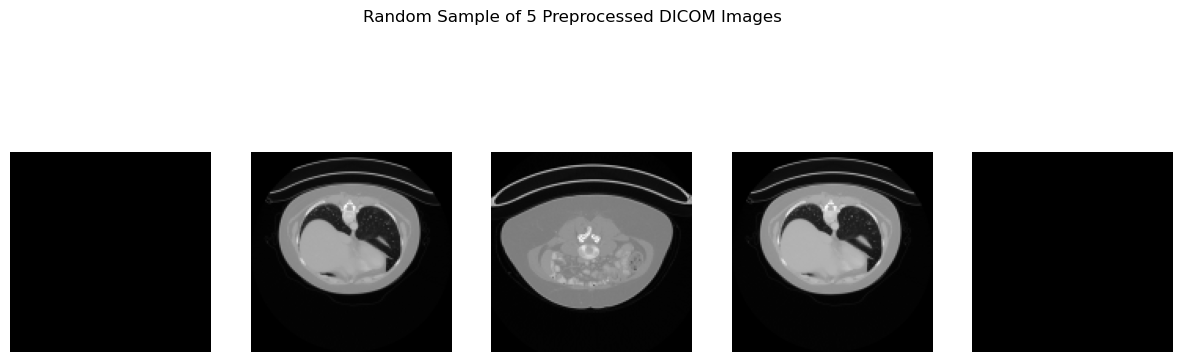

In [9]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# -----------------------------
# Load and Preprocess DICOM Images (No CT Windowing)
# -----------------------------
def load_dicom_images(base_path, img_size=(128, 128)):
    image_list = []
    skipped_files = 0

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(dicom_path)
                    if "PixelData" not in dicom_data:
                        skipped_files += 1
                        continue

                    raw_img = dicom_data.pixel_array.astype(np.float32)

                    # Normalize using full image range
                    min_val = np.min(raw_img)
                    max_val = np.max(raw_img)
                    norm_img = (raw_img - min_val) / (max_val - min_val + 1e-5)  # [0, 1]

                    # Resize
                    resized_img = cv2.resize(norm_img, img_size, interpolation=cv2.INTER_AREA)

                    # Expand for channel
                    img_array = np.expand_dims(resized_img, axis=-1)

                    image_list.append(img_array)

                except Exception as e:
                    print(f"❌ Error reading {dicom_path}: {e}")
                    skipped_files += 1

    if not image_list:
        raise ValueError("⚠️ No valid DICOM images found!")

    # Convert and normalize for GANs
    image_data = np.array(image_list)
    image_data = (image_data - 0.5) * 2  # Normalize to [-1, 1]

    print(f"✅ Loaded {image_data.shape[0]} images of shape {image_data.shape[1:]}")
    if skipped_files:
        print(f"⚠️ Skipped {skipped_files} files (invalid or no pixel data)")

    return image_data

# -----------------------------
# Visualization Function
# -----------------------------
def show_sample_images(image_data, num_samples=5):
    indices = random.sample(range(len(image_data)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(indices):
        axes[i].imshow(((image_data[idx].squeeze() + 1) / 2), cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Random Sample of {num_samples} Preprocessed DICOM Images")
    plt.show()

# -----------------------------
# Run the Loader
# -----------------------------
dicom_path = r"C:\ct data set\Pancreas-CT data\Pancreas-CT"
image_data = load_dicom_images(dicom_path)
show_sample_images(image_data)


✅ Loaded 18942 images of shape (128, 128, 1)


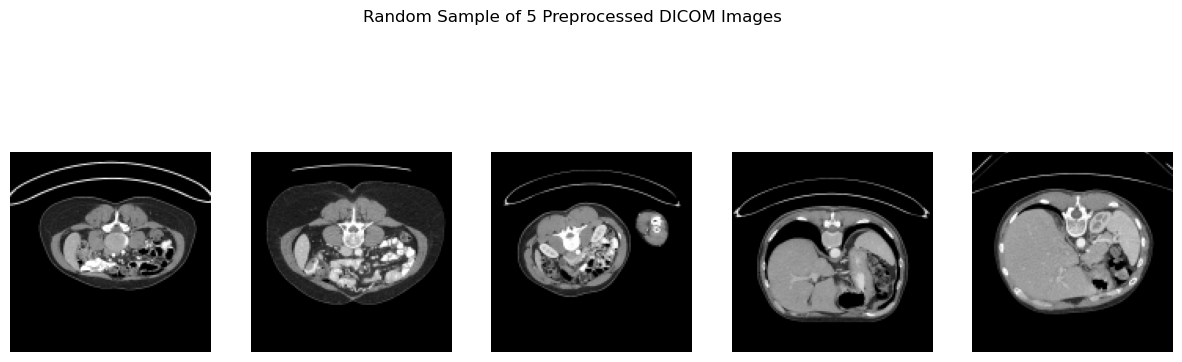

In [11]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# -----------------------------
# CT Windowing Function
# -----------------------------
def apply_window(image, center=40, width=400):
    img_min = center - width // 2
    img_max = center + width // 2
    windowed = np.clip(image, img_min, img_max)
    return (windowed - img_min) / (img_max - img_min + 1e-5)  # Normalize safely

# -----------------------------
# Load and Preprocess DICOM Images
# -----------------------------
def load_dicom_images(base_path, img_size=(128, 128), center=40, width=400):
    image_list = []
    skipped_files = 0

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                try:
                    dicom_data = pydicom.dcmread(dicom_path)
                    if "PixelData" not in dicom_data:
                        skipped_files += 1
                        continue

                    raw_img = dicom_data.pixel_array.astype(np.float32)

                    # Apply windowing
                    windowed_img = apply_window(raw_img, center, width)

                    # Resize
                    resized_img = cv2.resize(windowed_img, img_size, interpolation=cv2.INTER_AREA)

                    # Expand for channel
                    img_array = np.expand_dims(resized_img, axis=-1)

                    image_list.append(img_array)

                except Exception as e:
                    print(f"❌ Error reading {dicom_path}: {e}")
                    skipped_files += 1

    if not image_list:
        raise ValueError("⚠️ No valid DICOM images found!")

    # Convert and normalize
    image_data = np.array(image_list)
    image_data = (image_data - 0.5) * 2  # Normalize to [-1, 1] for GANs

    print(f"✅ Loaded {image_data.shape[0]} images of shape {image_data.shape[1:]}")
    if skipped_files:
        print(f"⚠️ Skipped {skipped_files} files (invalid or no pixel data)")

    return image_data

# -----------------------------
# Visualization Function
# -----------------------------
def show_sample_images(image_data, num_samples=5):
    indices = random.sample(range(len(image_data)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(indices):
        axes[i].imshow(((image_data[idx].squeeze() + 1) / 2), cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Random Sample of {num_samples} Preprocessed DICOM Images")
    plt.show()

# -----------------------------
# Run the Loader
# -----------------------------
dicom_path = r"C:\ct data set\Pancreas-CT data\Pancreas-CT"
image_data = load_dicom_images(dicom_path)
show_sample_images(image_data)


In [13]:
import os
import pydicom
import numpy as np
import cv2

# Define paths
base_path = r"C:\ct data set\Pancreas-CT data\Pancreas-CT"
output_dir = r"C:\ct data set\Pancreas-CT data\Numpy_data"
os.makedirs(output_dir, exist_ok=True)

# Collect all DICOM file paths
dicom_files = [os.path.join(root, file)
               for root, _, files in os.walk(base_path)
               for file in files if file.lower().endswith(".dcm")]

if not dicom_files:
    print("❌ No DICOM files found.")
    exit()

total_files = len(dicom_files)
print(f"📂 Found {total_files} DICOM files. Starting processing...")

# Stats tracking
processed_count, missing_pixel_data, unsupported_format = 0, 0, 0
corrupt_files = []

# ------------------ WINDOWING + CLAHE FUNCTION ------------------ #
def apply_window(image, center=40, width=350, gamma=1.2, apply_clahe=True):
    img_min = center - width // 2
    img_max = center + width // 2
    windowed = np.clip(image, img_min, img_max)
    normalized = (windowed - img_min) / (img_max - img_min + 1e-5)
    adjusted = np.power(normalized, gamma)

    # Apply CLAHE for better local contrast
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        adjusted = (adjusted * 255).astype(np.uint8)
        adjusted = clahe.apply(adjusted)
        adjusted = adjusted.astype(np.float32) / 255.0  # Re-normalize

    return adjusted

# ------------------ PROCESSING FUNCTION ------------------ #
def process_dicom_to_numpy(dicom_path, output_dir, index):
    global missing_pixel_data, unsupported_format, processed_count

    try:
        dicom_data = pydicom.dcmread(dicom_path, force=True)
        if "PixelData" not in dicom_data:
            missing_pixel_data += 1
            return False

        try:
            img_array = dicom_data.pixel_array.astype(np.float32)
        except Exception:
            unsupported_format += 1
            return False

        if len(img_array.shape) == 3 and img_array.shape[-1] == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

        # Apply windowing + contrast adjustment
        img_array = apply_window(img_array, center=40, width=350, gamma=1.2, apply_clahe=True)

        # Resize to (128x128)
        img_array = cv2.resize(img_array, (128, 128), interpolation=cv2.INTER_AREA)

        # Save as .npy
        filename = os.path.join(output_dir, f"image_{index:05d}.npy")
        np.save(filename, img_array)

        processed_count += 1
        return True

    except Exception:
        corrupt_files.append(dicom_path)
        return False

# ------------------ MAIN LOOP ------------------ #
for idx, dicom_path in enumerate(dicom_files):
    process_dicom_to_numpy(dicom_path, output_dir, idx)

# ------------------ SUMMARY ------------------ #
saved_files = len(os.listdir(output_dir))
file_sizes = [os.path.getsize(os.path.join(output_dir, f)) for f in os.listdir(output_dir)]

print("\n🎉 Processing Complete!")
print(f"✅ Converted: {processed_count}/{total_files} files.")
print(f"⚠️ Missing pixel data: {missing_pixel_data}")
print(f"🛑 Unsupported formats: {unsupported_format}")
print(f"❌ Corrupt/unreadable: {len(corrupt_files)}")
print(f"📁 Output Numpy files: {saved_files}")
print(f"📏 Avg file size: {np.mean(file_sizes) / 1024:.2f} KB")

if corrupt_files:
    print("\n📌 Sample corrupt files:")
    for file in corrupt_files[:5]:
        print(file)


📂 Found 18942 DICOM files. Starting processing...

🎉 Processing Complete!
✅ Converted: 18942/18942 files.
⚠️ Missing pixel data: 0
🛑 Unsupported formats: 0
❌ Corrupt/unreadable: 0
📁 Output Numpy files: 18942
📏 Avg file size: 64.12 KB


✅ Found 18942 .npy training images.


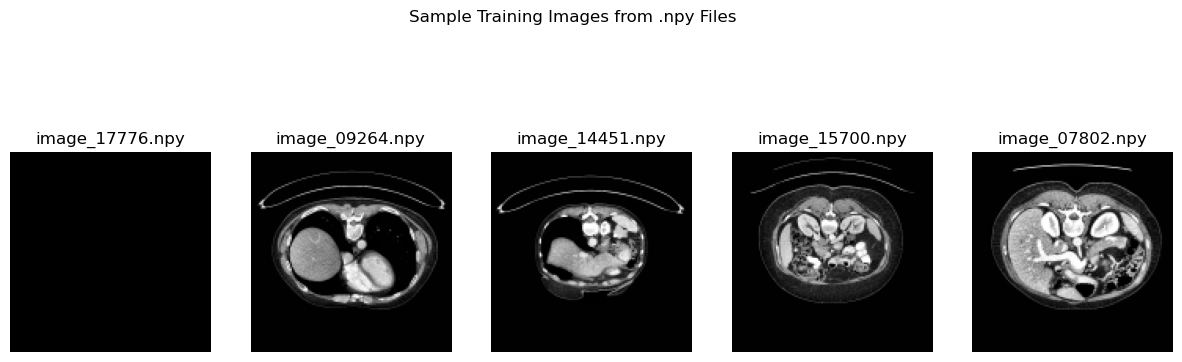

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Path where your .npy training images are saved
npy_folder = r"C:\ct data set\Pancreas-CT data\Numpy_data"

# Get list of .npy files
npy_files = [f for f in os.listdir(npy_folder) if f.endswith('.npy')]
print(f"✅ Found {len(npy_files)} .npy training images.")

# Randomly select a few to show
num_samples = 5
sample_files = random.sample(npy_files, num_samples)

# Plot
plt.figure(figsize=(15, 5))
for i, filename in enumerate(sample_files):
    img = np.load(os.path.join(npy_folder, filename))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')

plt.suptitle("Sample Training Images from .npy Files")
plt.show()


In [17]:
import os
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import glob
import logging

# ======================= CONFIG =======================
npy_dir = r"C:\\ct data set\\Pancreas-CT data\\Numpy_data"
split_dir = r"C:\ct data set\Pancreas-CT data\Split_Data"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Validate split ratios
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

# ===================== SETUP LOGGING =====================
logging.basicConfig(filename='file_splitter.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# ================ CLEAN OUTPUT FOLDERS ================
for dir in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir, exist_ok=True)

# ================ GATHER .NPY FILES ===================
print(f"🔍 Searching for .npy files in: {npy_dir}")
npy_files = glob.glob(os.path.join(npy_dir, '**', '*.npy'), recursive=True)

if len(npy_files) == 0:
    print(f"⚠️ Warning: No .npy files found in: {npy_dir}")
    logging.warning("No .npy files found in the specified directory.")
    sys.exit(1)

print(f"✅ Found {len(npy_files)} .npy files")

# ================ SPLIT FILES =========================
train_files, test_val_files = train_test_split(npy_files, test_size=(1 - train_ratio), random_state=42, shuffle=True)
val_files, test_files = train_test_split(test_val_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=True)

# ================ MOVE FILES ==========================
def move_files(file_list, dest_dir, move=True):
    operation = shutil.move if move else shutil.copy2
    for file_path in tqdm(file_list, desc=f"📂 Processing {os.path.basename(dest_dir)}", unit="file"):
        # Handle duplicate names by adding subfolder prefix
        base_name = os.path.basename(file_path)
        prefix = os.path.basename(os.path.dirname(file_path))
        new_name = f"{prefix}_{base_name}"
        dest_path = os.path.join(dest_dir, new_name)

        try:
            if not os.path.exists(dest_path):
                operation(file_path, dest_path)
        except Exception as e:
            logging.error(f"Error moving file {file_path} to {dest_path}: {e}")

# Move files
move_files(train_files, train_dir, move=True)
move_files(val_files, val_dir, move=True)
move_files(test_files, test_dir, move=True)

# ================ SUMMARY =============================
print("\n✅ Dataset split complete!")
print(f"📁 Train: {len(train_files)} files ({train_ratio*100:.1f}%)")
print(f"📁 Validation: {len(val_files)} files ({val_ratio*100:.1f}%)")
print(f"📁 Test: {len(test_files)} files ({test_ratio*100:.1f}%)") 

# Log summary
logging.info(f"Dataset split complete: Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

🔍 Searching for .npy files in: C:\\ct data set\\Pancreas-CT data\\Numpy_data
✅ Found 18942 .npy files


📂 Processing test: 100%|██████████| 2842/2842 [00:01<00:00, 2419.20file/s]


✅ Dataset split complete!
📁 Train: 13259 files (70.0%)
📁 Validation: 2841 files (15.0%)
📁 Test: 2842 files (15.0%)


In [19]:
def load_npy_images(folder):
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npy')])
    images = [np.load(f) for f in files]
    images = np.array(images)
    images = images[..., np.newaxis]  # Add channel dimension (128, 128, 1)
    return images.astype(np.float32)

train_images = load_npy_images(train_dir)
val_images = load_npy_images(val_dir)
test_images = load_npy_images(test_dir)

print("Train shape:", train_images.shape)
print("Val shape:", val_images.shape)
print("Test shape:", test_images.shape)


Train shape: (13259, 128, 128, 1)
Val shape: (2841, 128, 128, 1)
Test shape: (2842, 128, 128, 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, BatchNormalization, LeakyReLU, Reshape, Dropout,
    Conv2DTranspose, Conv2D
)
from tensorflow.keras.regularizers import l2

def build_generator(latent_dim=100):
    model = tf.keras.Sequential([
        # Input layer with latent_dim as the shape of the input vector
        tf.keras.Input(shape=(latent_dim,)),

        # Initial Dense layer to project latent space into a larger space (e.g., 8x8x512)
        Dense(8 * 8 * 512, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),  # Updated to 'negative_slope' instead of 'alpha'
        Reshape((8, 8, 512)),  # Reshape to (8, 8, 512)
        Dropout(0.3),

        # Upsample to (16x16)
        Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),  # Updated to 'negative_slope' instead of 'alpha'
        Dropout(0.3),

        # Upsample to (32x32)
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),  # Updated to 'negative_slope' instead of 'alpha'

        # Upsample to (64x64)
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                        kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
        BatchNormalization(momentum=0.8),
        LeakyReLU(negative_slope=0.2),  # Updated to 'negative_slope' instead of 'alpha'

        # Final layer: output (128x128x1) grayscale image with tanh activation
        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                        activation='tanh')
    ])
    return model

# Build & summarize generator
if __name__ == "__main__":
    generator = build_generator()
    generator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 1)    │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,712,064 (29.42 MB)

 Trainable params: 7,645,632 (29.17 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, LeakyReLU, Flatten, Dropout, Dense
)
from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = tf.keras.Sequential([
        # Input: 128x128x1 grayscale image
        Conv2D(32, (5, 5), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4),
               input_shape=(128, 128, 1), name="conv1"),
        LeakyReLU(negative_slope=0.2, name="lrelu1"),  # Updated to 'negative_slope' instead of 'alpha',
        
        # Downsample to 64x64
        Conv2D(64, (5, 5), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name="conv2"),
        BatchNormalization(name="batchnorm2"),
        LeakyReLU(negative_slope=0.2, name="lrelu2"),  # Updated to 'negative_slope' instead of 'alpha'
        Dropout(0.3, name="dropout2"),

        # Downsample to 32x32
        Conv2D(128, (5, 5), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name="conv3"),
        BatchNormalization(name="batchnorm3"),
        LeakyReLU(negative_slope=0.2, name="lrelu3"),  # Updated to 'negative_slope' instead of 'alpha'
        Dropout(0.3, name="dropout3"),

        # Downsample to 16x16
        Conv2D(256, (5, 5), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), name="conv4"),
        BatchNormalization(name="batchnorm4"),
        LeakyReLU(negative_slope=0.2, name="lrelu4"),  # Updated to 'negative_slope' instead of 'alpha'

        # Flatten and Classify
        Flatten(name="flatten"),
        Dense(1, activation='sigmoid', kernel_initializer='he_normal',
              kernel_regularizer=l2(1e-4), name="dense_output")  # Added L2 regularization
    ])

    return model

# Build & summarize model
if __name__ == "__main__":
    discriminator = build_discriminator()
    print("\nDiscriminator Summary:")
    discriminator.summary()



Discriminator Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu1 (LeakyReLU)              │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm2 (BatchNormalization) │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu2 (LeakyReLU)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm3 (BatchNormalization) │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu3 (LeakyReLU)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm4 (BatchNormalization) │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu4 (LeakyReLU)              │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,094,657 (4.18 MB)

 Trainable params: 1,093,761 (4.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [9]:
import os
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================
# Training parameters
# ============================
EPOCHS = 200
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16
SAVE_IMAGE_EVERY = 1
CHECKPOINT_EVERY = 10

# Fixed noise seed for consistent visualization
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# ============================
# Update Directories
# ============================
output_dir = r"C:\ct data set\Pancreas-CT data\gan_image_individual"
gen_ckpt_dir = r"C:\ct data set\Pancreas-CT data\model_checkpoints\generator"
disc_ckpt_dir = r"C:\ct data set\Pancreas-CT data\model_checkpoints\discriminator"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(gen_ckpt_dir, exist_ok=True)
os.makedirs(disc_ckpt_dir, exist_ok=True)

# ============================
# Save individual generated images
# ============================
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        img = predictions[i, :, :, 0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, f"epoch_{epoch:04d}_img_{i:02d}.png"))
        plt.close()

# ============================
# Save models as .keras
# ============================
def save_models(generator, discriminator, epoch):
    gen_path = os.path.join(gen_ckpt_dir, f"generator_epoch_{epoch:04d}.keras")
    disc_path = os.path.join(disc_ckpt_dir, f"discriminator_epoch_{epoch:04d}.keras")
    generator.save(gen_path)
    discriminator.save(disc_path)

# ============================
# Loss functions
# ============================
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Corrected: from_logits=False

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# ============================
# Train step
# ============================
@tf.function
def train_step(real_images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Metrics
    real_acc = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))
    disc_acc = 0.5 * (real_acc + fake_acc)
    gen_fooling = tf.reduce_mean(tf.cast(fake_output > 0, tf.float32))

    return gen_loss, disc_loss, disc_acc, gen_fooling

# ============================
# Training loop
# ============================
def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer):
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        start = time.time()
        batch_bar = tqdm(dataset, desc=f"Epoch {epoch}/{epochs}", leave=True)

        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0

        for real_images in batch_bar:
            if real_images is None:
                continue

            gen_loss, disc_loss, disc_acc, gen_fooling = train_step(real_images, generator, discriminator, generator_optimizer, discriminator_optimizer)

            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            num_batches += 1

            batch_bar.set_postfix(
                G_Loss=f"{gen_loss:.4f}", D_Loss=f"{disc_loss:.4f}",
                Disc_Acc=f"{disc_acc:.4f}", Gen_Fooling=f"{gen_fooling:.4f}"
            )

        avg_gen_loss = total_gen_loss / max(num_batches, 1)
        avg_disc_loss = total_disc_loss / max(num_batches, 1)

        if epoch % SAVE_IMAGE_EVERY == 0:
            generate_and_save_images(generator, epoch, seed)

        if epoch % CHECKPOINT_EVERY == 0:
            save_models(generator, discriminator, epoch)

        elapsed_time = time.time() - start
        remaining_time = (time.time() - start_time) / epoch * (epochs - epoch)

        print(f"✅ Epoch {epoch}/{epochs} - Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f} | Time: {elapsed_time:.2f}s | ETA: {remaining_time/60:.2f} min")

    print("\n🎉 Training Complete! Total Time:", round((time.time() - start_time) / 60, 2), "mins")

# ============================
# Load and Normalize .npy Images
# ============================
def load_numpy_images(folder_path):
    images = []
    
    # Fetch all .npy files
    npy_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]
    
    if not npy_files:
        raise FileNotFoundError(f"⚠️ No .npy files found in {folder_path}!")

    for file in tqdm(npy_files, desc="📂 Loading Images"):
        try:
            img = np.load(os.path.join(folder_path, file))

            # Ensure correct shape (128, 128, 1)
            if img.ndim == 2:  # (128,128) -> (128,128,1)
                img = np.expand_dims(img, axis=-1)
            
            images.append(img)
        
        except Exception as e:
            print(f"❌ Error loading {file}: {e}")

    images = np.array(images, dtype=np.float32)
    
    # Normalize images to [-1,1] for tanh activation
    return (images - 0.5) * 2.0  

# === Load Training Data ===
train_images = load_numpy_images(r"C:\ct data set\Pancreas-CT data\Split_Data\train")

# Convert to TensorFlow dataset
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(1000)  # Buffer for shuffling
                 .batch(32)  # Batch size of 32
                 .prefetch(tf.data.AUTOTUNE))  # Prefetch for optimization

print(f"✅ Loaded {len(train_images)} images into dataset!")

# ============================
# Optimizers
# ============================
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Assuming you have already defined and built the generator and discriminator
# generator = build_generator()
# discriminator = build_discriminator()

# Start the training process
train(train_dataset, EPOCHS, generator, discriminator, generator_optimizer, discriminator_optimizer)


📂 Loading Images: 100%|██████████| 13259/13259 [00:11<00:00, 1137.08it/s]


✅ Loaded 13259 images into dataset!


Epoch 1/200: 100%|██████████| 415/415 [09:48<00:00,  1.42s/it, D_Loss=0.1322, Disc_Acc=0.5000, G_Loss=6.0413, Gen_Fooling=1.0000]


✅ Epoch 1/200 - Gen Loss: 4.9717 | Disc Loss: 0.0974 | Time: 590.86s | ETA: 1959.69 min


Epoch 2/200: 100%|██████████| 415/415 [09:40<00:00,  1.40s/it, D_Loss=0.0115, Disc_Acc=0.5000, G_Loss=7.0749, Gen_Fooling=1.0000]


✅ Epoch 2/200 - Gen Loss: 5.1053 | Disc Loss: 0.1121 | Time: 582.37s | ETA: 1935.83 min


Epoch 3/200: 100%|██████████| 415/415 [09:28<00:00,  1.37s/it, D_Loss=0.0024, Disc_Acc=0.5000, G_Loss=8.5300, Gen_Fooling=1.0000]


✅ Epoch 3/200 - Gen Loss: 6.3029 | Disc Loss: 0.0622 | Time: 569.90s | ETA: 1907.76 min


Epoch 4/200: 100%|██████████| 415/415 [09:03<00:00,  1.31s/it, D_Loss=0.0310, Disc_Acc=0.5000, G_Loss=8.0402, Gen_Fooling=1.0000] 


✅ Epoch 4/200 - Gen Loss: 6.9060 | Disc Loss: 0.0543 | Time: 544.18s | ETA: 1867.97 min


Epoch 5/200: 100%|██████████| 415/415 [08:46<00:00,  1.27s/it, D_Loss=0.0111, Disc_Acc=0.5000, G_Loss=6.9757, Gen_Fooling=1.0000] 


✅ Epoch 5/200 - Gen Loss: 7.0585 | Disc Loss: 0.0479 | Time: 527.37s | ETA: 1829.55 min


Epoch 6/200: 100%|██████████| 415/415 [09:19<00:00,  1.35s/it, D_Loss=0.0510, Disc_Acc=0.5000, G_Loss=8.6884, Gen_Fooling=1.0000] 


✅ Epoch 6/200 - Gen Loss: 7.3274 | Disc Loss: 0.0381 | Time: 561.10s | ETA: 1819.18 min


Epoch 7/200: 100%|██████████| 415/415 [08:55<00:00,  1.29s/it, D_Loss=0.0410, Disc_Acc=0.5000, G_Loss=6.1915, Gen_Fooling=1.0000] 


✅ Epoch 7/200 - Gen Loss: 7.6991 | Disc Loss: 0.0314 | Time: 537.54s | ETA: 1798.27 min


Epoch 8/200: 100%|██████████| 415/415 [08:57<00:00,  1.30s/it, D_Loss=0.0028, Disc_Acc=0.5000, G_Loss=7.3935, Gen_Fooling=1.0000] 


✅ Epoch 8/200 - Gen Loss: 7.8751 | Disc Loss: 0.0283 | Time: 538.64s | ETA: 1780.79 min


Epoch 9/200: 100%|██████████| 415/415 [08:50<00:00,  1.28s/it, D_Loss=0.0257, Disc_Acc=0.5000, G_Loss=5.8187, Gen_Fooling=1.0000] 


✅ Epoch 9/200 - Gen Loss: 8.3999 | Disc Loss: 0.0256 | Time: 531.69s | ETA: 1762.74 min


Epoch 10/200: 100%|██████████| 415/415 [08:44<00:00,  1.26s/it, D_Loss=0.0654, Disc_Acc=0.5000, G_Loss=4.9405, Gen_Fooling=1.0000] 


✅ Epoch 10/200 - Gen Loss: 8.5941 | Disc Loss: 0.0201 | Time: 525.67s | ETA: 1744.62 min


Epoch 11/200: 100%|██████████| 415/415 [08:58<00:00,  1.30s/it, D_Loss=0.1263, Disc_Acc=0.5000, G_Loss=7.3287, Gen_Fooling=1.0000] 


✅ Epoch 11/200 - Gen Loss: 8.5091 | Disc Loss: 0.0288 | Time: 539.36s | ETA: 1732.12 min


Epoch 12/200: 100%|██████████| 415/415 [09:06<00:00,  1.32s/it, D_Loss=0.0021, Disc_Acc=0.5000, G_Loss=9.1956, Gen_Fooling=1.0000] 


✅ Epoch 12/200 - Gen Loss: 8.4568 | Disc Loss: 0.0254 | Time: 547.95s | ETA: 1722.46 min


Epoch 13/200: 100%|██████████| 415/415 [09:07<00:00,  1.32s/it, D_Loss=0.0134, Disc_Acc=0.5000, G_Loss=7.0630, Gen_Fooling=1.0000] 


✅ Epoch 13/200 - Gen Loss: 8.3133 | Disc Loss: 0.0166 | Time: 548.85s | ETA: 1713.09 min


Epoch 14/200: 100%|██████████| 415/415 [09:12<00:00,  1.33s/it, D_Loss=0.0111, Disc_Acc=0.5000, G_Loss=9.4878, Gen_Fooling=1.0000] 


✅ Epoch 14/200 - Gen Loss: 8.8452 | Disc Loss: 0.0237 | Time: 554.50s | ETA: 1705.00 min


Epoch 15/200: 100%|██████████| 415/415 [4:37:54<00:00, 40.18s/it, D_Loss=0.0181, Disc_Acc=0.5000, G_Loss=6.2772, Gen_Fooling=1.0000]     


✅ Epoch 15/200 - Gen Loss: 8.5726 | Disc Loss: 0.0183 | Time: 16676.26s | ETA: 5010.67 min


Epoch 16/200: 100%|██████████| 415/415 [08:43<00:00,  1.26s/it, D_Loss=0.0058, Disc_Acc=0.5000, G_Loss=8.7268, Gen_Fooling=1.0000] 


✅ Epoch 16/200 - Gen Loss: 8.6272 | Disc Loss: 0.0204 | Time: 524.33s | ETA: 4772.61 min


Epoch 17/200: 100%|██████████| 415/415 [08:39<00:00,  1.25s/it, D_Loss=0.0034, Disc_Acc=0.5000, G_Loss=9.2657, Gen_Fooling=1.0000] 


✅ Epoch 17/200 - Gen Loss: 9.1124 | Disc Loss: 0.0168 | Time: 520.35s | ETA: 4560.81 min


Epoch 18/200: 100%|██████████| 415/415 [08:47<00:00,  1.27s/it, D_Loss=0.0045, Disc_Acc=0.5000, G_Loss=7.7251, Gen_Fooling=1.0000] 


✅ Epoch 18/200 - Gen Loss: 8.2101 | Disc Loss: 0.0206 | Time: 528.74s | ETA: 4373.00 min


Epoch 19/200: 100%|██████████| 415/415 [08:39<00:00,  1.25s/it, D_Loss=0.0480, Disc_Acc=0.5000, G_Loss=8.0982, Gen_Fooling=1.0000] 


✅ Epoch 19/200 - Gen Loss: 8.6211 | Disc Loss: 0.0190 | Time: 520.72s | ETA: 4202.76 min


Epoch 20/200: 100%|██████████| 415/415 [08:32<00:00,  1.24s/it, D_Loss=0.0050, Disc_Acc=0.5000, G_Loss=7.1997, Gen_Fooling=1.0000] 


✅ Epoch 20/200 - Gen Loss: 8.8631 | Disc Loss: 0.0164 | Time: 513.92s | ETA: 4047.65 min


Epoch 21/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0121, Disc_Acc=0.5000, G_Loss=9.2819, Gen_Fooling=1.0000] 


✅ Epoch 21/200 - Gen Loss: 8.7819 | Disc Loss: 0.0110 | Time: 516.37s | ETA: 3906.84 min


Epoch 22/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0128, Disc_Acc=0.5000, G_Loss=18.1522, Gen_Fooling=1.0000]


✅ Epoch 22/200 - Gen Loss: 9.7393 | Disc Loss: 0.0225 | Time: 518.07s | ETA: 3778.29 min


Epoch 23/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0215, Disc_Acc=0.5000, G_Loss=6.8600, Gen_Fooling=1.0000] 


✅ Epoch 23/200 - Gen Loss: 9.3160 | Disc Loss: 0.0199 | Time: 517.88s | ETA: 3660.13 min


Epoch 24/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0006, Disc_Acc=0.5000, G_Loss=9.8566, Gen_Fooling=1.0000] 


✅ Epoch 24/200 - Gen Loss: 8.4182 | Disc Loss: 0.0256 | Time: 516.45s | ETA: 3550.93 min


Epoch 25/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=1.0151, Disc_Acc=0.5000, G_Loss=7.1507, Gen_Fooling=1.0000] 


✅ Epoch 25/200 - Gen Loss: 8.9582 | Disc Loss: 0.0177 | Time: 510.69s | ETA: 3449.11 min


Epoch 26/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.0352, Disc_Acc=0.5000, G_Loss=14.0095, Gen_Fooling=1.0000]


✅ Epoch 26/200 - Gen Loss: 8.8379 | Disc Loss: 0.0211 | Time: 513.41s | ETA: 3354.76 min


Epoch 27/200: 100%|██████████| 415/415 [09:10<00:00,  1.33s/it, D_Loss=0.0021, Disc_Acc=0.5000, G_Loss=9.4075, Gen_Fooling=1.0000] 


✅ Epoch 27/200 - Gen Loss: 8.6608 | Disc Loss: 0.0271 | Time: 552.89s | ETA: 3270.99 min


Epoch 28/200: 100%|██████████| 415/415 [08:22<00:00,  1.21s/it, D_Loss=0.0098, Disc_Acc=0.5000, G_Loss=7.2130, Gen_Fooling=1.0000] 


✅ Epoch 28/200 - Gen Loss: 8.2700 | Disc Loss: 0.0173 | Time: 503.46s | ETA: 3187.48 min


Epoch 29/200: 100%|██████████| 415/415 [08:13<00:00,  1.19s/it, D_Loss=0.0019, Disc_Acc=0.5000, G_Loss=8.7853, Gen_Fooling=1.0000] 


✅ Epoch 29/200 - Gen Loss: 9.1454 | Disc Loss: 0.0209 | Time: 494.84s | ETA: 3108.31 min


Epoch 30/200: 100%|██████████| 415/415 [08:12<00:00,  1.19s/it, D_Loss=0.0218, Disc_Acc=0.5000, G_Loss=6.8388, Gen_Fooling=1.0000] 


✅ Epoch 30/200 - Gen Loss: 9.0070 | Disc Loss: 0.0179 | Time: 493.87s | ETA: 3033.77 min


Epoch 31/200: 100%|██████████| 415/415 [08:08<00:00,  1.18s/it, D_Loss=0.0167, Disc_Acc=0.5000, G_Loss=10.6132, Gen_Fooling=1.0000]


✅ Epoch 31/200 - Gen Loss: 8.8982 | Disc Loss: 0.0270 | Time: 489.32s | ETA: 2963.10 min


Epoch 32/200: 100%|██████████| 415/415 [08:12<00:00,  1.19s/it, D_Loss=0.0135, Disc_Acc=0.5000, G_Loss=8.9433, Gen_Fooling=1.0000] 


✅ Epoch 32/200 - Gen Loss: 8.7923 | Disc Loss: 0.0216 | Time: 494.00s | ETA: 2896.74 min


Epoch 33/200: 100%|██████████| 415/415 [08:15<00:00,  1.19s/it, D_Loss=0.0428, Disc_Acc=0.5000, G_Loss=6.1170, Gen_Fooling=1.0000] 


✅ Epoch 33/200 - Gen Loss: 9.1154 | Disc Loss: 0.0178 | Time: 497.97s | ETA: 2834.24 min


Epoch 34/200: 100%|██████████| 415/415 [08:09<00:00,  1.18s/it, D_Loss=0.0016, Disc_Acc=0.5000, G_Loss=9.1594, Gen_Fooling=1.0000] 


✅ Epoch 34/200 - Gen Loss: 9.5343 | Disc Loss: 0.0172 | Time: 490.80s | ETA: 2774.35 min


Epoch 35/200: 100%|██████████| 415/415 [08:15<00:00,  1.19s/it, D_Loss=0.0046, Disc_Acc=0.5000, G_Loss=8.5420, Gen_Fooling=1.0000] 


✅ Epoch 35/200 - Gen Loss: 9.3845 | Disc Loss: 0.0153 | Time: 496.70s | ETA: 2717.87 min


Epoch 36/200: 100%|██████████| 415/415 [08:12<00:00,  1.19s/it, D_Loss=0.0071, Disc_Acc=0.5000, G_Loss=7.8797, Gen_Fooling=1.0000] 


✅ Epoch 36/200 - Gen Loss: 9.2695 | Disc Loss: 0.0141 | Time: 493.14s | ETA: 2663.80 min


Epoch 37/200: 100%|██████████| 415/415 [08:11<00:00,  1.18s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=10.7092, Gen_Fooling=1.0000]


✅ Epoch 37/200 - Gen Loss: 9.8088 | Disc Loss: 0.0201 | Time: 492.89s | ETA: 2612.19 min


Epoch 38/200: 100%|██████████| 415/415 [08:11<00:00,  1.19s/it, D_Loss=0.0100, Disc_Acc=0.5000, G_Loss=7.5246, Gen_Fooling=1.0000] 


✅ Epoch 38/200 - Gen Loss: 10.0811 | Disc Loss: 0.0248 | Time: 492.99s | ETA: 2562.87 min


Epoch 39/200: 100%|██████████| 415/415 [09:04<00:00,  1.31s/it, D_Loss=0.0082, Disc_Acc=0.5000, G_Loss=7.2484, Gen_Fooling=1.0000] 


✅ Epoch 39/200 - Gen Loss: 9.5528 | Disc Loss: 0.0194 | Time: 545.62s | ETA: 2519.29 min


Epoch 40/200: 100%|██████████| 415/415 [08:36<00:00,  1.24s/it, D_Loss=0.0022, Disc_Acc=0.5000, G_Loss=9.8292, Gen_Fooling=1.0000] 


✅ Epoch 40/200 - Gen Loss: 9.0581 | Disc Loss: 0.0160 | Time: 517.97s | ETA: 2475.58 min


Epoch 41/200: 100%|██████████| 415/415 [08:19<00:00,  1.20s/it, D_Loss=0.0112, Disc_Acc=0.5000, G_Loss=9.5182, Gen_Fooling=1.0000] 


✅ Epoch 41/200 - Gen Loss: 9.8504 | Disc Loss: 0.0103 | Time: 500.86s | ETA: 2432.48 min


Epoch 42/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0099, Disc_Acc=0.5000, G_Loss=6.0425, Gen_Fooling=1.0000] 


✅ Epoch 42/200 - Gen Loss: 10.2266 | Disc Loss: 0.0163 | Time: 507.55s | ETA: 2391.45 min


Epoch 43/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0228, Disc_Acc=0.5000, G_Loss=6.2657, Gen_Fooling=1.0000] 


✅ Epoch 43/200 - Gen Loss: 9.5718 | Disc Loss: 0.0178 | Time: 508.88s | ETA: 2352.02 min


Epoch 44/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0027, Disc_Acc=0.5000, G_Loss=8.5900, Gen_Fooling=1.0000] 


✅ Epoch 44/200 - Gen Loss: 9.5722 | Disc Loss: 0.0166 | Time: 508.40s | ETA: 2313.96 min


Epoch 45/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0101, Disc_Acc=0.5000, G_Loss=7.1913, Gen_Fooling=1.0000] 


✅ Epoch 45/200 - Gen Loss: 8.7986 | Disc Loss: 0.0233 | Time: 508.13s | ETA: 2277.21 min


Epoch 46/200: 100%|██████████| 415/415 [08:24<00:00,  1.21s/it, D_Loss=0.0016, Disc_Acc=0.5000, G_Loss=8.7718, Gen_Fooling=1.0000] 


✅ Epoch 46/200 - Gen Loss: 8.9929 | Disc Loss: 0.0219 | Time: 505.34s | ETA: 2241.53 min


Epoch 47/200: 100%|██████████| 415/415 [08:24<00:00,  1.22s/it, D_Loss=0.0058, Disc_Acc=0.5000, G_Loss=8.4098, Gen_Fooling=1.0000] 


✅ Epoch 47/200 - Gen Loss: 9.0567 | Disc Loss: 0.0186 | Time: 507.24s | ETA: 2207.11 min


Epoch 48/200: 100%|██████████| 415/415 [08:22<00:00,  1.21s/it, D_Loss=0.0005, Disc_Acc=0.5000, G_Loss=12.1259, Gen_Fooling=1.0000]


✅ Epoch 48/200 - Gen Loss: 9.4560 | Disc Loss: 0.0195 | Time: 503.54s | ETA: 2173.58 min


Epoch 49/200: 100%|██████████| 415/415 [08:22<00:00,  1.21s/it, D_Loss=0.0014, Disc_Acc=0.5000, G_Loss=9.7998, Gen_Fooling=1.0000] 


✅ Epoch 49/200 - Gen Loss: 10.0561 | Disc Loss: 0.0218 | Time: 503.21s | ETA: 2141.06 min


Epoch 50/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0015, Disc_Acc=0.5000, G_Loss=10.7618, Gen_Fooling=1.0000]


✅ Epoch 50/200 - Gen Loss: 9.0051 | Disc Loss: 0.0172 | Time: 506.47s | ETA: 2109.66 min


Epoch 51/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0032, Disc_Acc=0.5000, G_Loss=8.1365, Gen_Fooling=1.0000] 


✅ Epoch 51/200 - Gen Loss: 9.6323 | Disc Loss: 0.0143 | Time: 510.48s | ETA: 2079.37 min


Epoch 52/200: 100%|██████████| 415/415 [08:20<00:00,  1.21s/it, D_Loss=0.0035, Disc_Acc=0.5000, G_Loss=8.9493, Gen_Fooling=1.0000] 


✅ Epoch 52/200 - Gen Loss: 9.9563 | Disc Loss: 0.0161 | Time: 501.49s | ETA: 2049.48 min


Epoch 53/200: 100%|██████████| 415/415 [08:22<00:00,  1.21s/it, D_Loss=0.0007, Disc_Acc=0.5000, G_Loss=12.1268, Gen_Fooling=1.0000]


✅ Epoch 53/200 - Gen Loss: 9.4878 | Disc Loss: 0.0201 | Time: 503.96s | ETA: 2020.52 min


Epoch 54/200: 100%|██████████| 415/415 [08:16<00:00,  1.20s/it, D_Loss=0.0391, Disc_Acc=0.5000, G_Loss=10.9863, Gen_Fooling=1.0000]


✅ Epoch 54/200 - Gen Loss: 9.7671 | Disc Loss: 0.0251 | Time: 497.58s | ETA: 1992.03 min


Epoch 55/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0021, Disc_Acc=0.5000, G_Loss=8.1697, Gen_Fooling=1.0000] 


✅ Epoch 55/200 - Gen Loss: 8.9792 | Disc Loss: 0.0116 | Time: 506.79s | ETA: 1964.69 min


Epoch 56/200: 100%|██████████| 415/415 [08:18<00:00,  1.20s/it, D_Loss=0.0309, Disc_Acc=0.5000, G_Loss=7.1185, Gen_Fooling=1.0000] 


✅ Epoch 56/200 - Gen Loss: 9.3434 | Disc Loss: 0.0137 | Time: 499.72s | ETA: 1937.71 min


Epoch 57/200: 100%|██████████| 415/415 [08:23<00:00,  1.21s/it, D_Loss=0.0015, Disc_Acc=0.5000, G_Loss=7.9681, Gen_Fooling=1.0000] 


✅ Epoch 57/200 - Gen Loss: 9.5351 | Disc Loss: 0.0129 | Time: 505.04s | ETA: 1911.61 min


Epoch 58/200: 100%|██████████| 415/415 [08:21<00:00,  1.21s/it, D_Loss=0.0023, Disc_Acc=0.5000, G_Loss=10.0317, Gen_Fooling=1.0000]


✅ Epoch 58/200 - Gen Loss: 10.3630 | Disc Loss: 0.0184 | Time: 502.10s | ETA: 1886.01 min


Epoch 59/200: 100%|██████████| 415/415 [08:04<00:00,  1.17s/it, D_Loss=0.0041, Disc_Acc=0.5000, G_Loss=9.4697, Gen_Fooling=1.0000] 


✅ Epoch 59/200 - Gen Loss: 9.6678 | Disc Loss: 0.0106 | Time: 485.23s | ETA: 1860.31 min


Epoch 60/200: 100%|██████████| 415/415 [08:14<00:00,  1.19s/it, D_Loss=0.0010, Disc_Acc=0.5000, G_Loss=11.4508, Gen_Fooling=1.0000]


✅ Epoch 60/200 - Gen Loss: 11.1769 | Disc Loss: 0.0132 | Time: 496.13s | ETA: 1835.63 min


Epoch 61/200: 100%|██████████| 415/415 [08:22<00:00,  1.21s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=10.0508, Gen_Fooling=1.0000]


✅ Epoch 61/200 - Gen Loss: 9.9209 | Disc Loss: 0.0095 | Time: 503.88s | ETA: 1811.77 min


Epoch 62/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0161, Disc_Acc=0.5000, G_Loss=8.9641, Gen_Fooling=1.0000] 


✅ Epoch 62/200 - Gen Loss: 9.3095 | Disc Loss: 0.0067 | Time: 506.22s | ETA: 1788.51 min


Epoch 63/200: 100%|██████████| 415/415 [08:23<00:00,  1.21s/it, D_Loss=0.0011, Disc_Acc=0.5000, G_Loss=7.6898, Gen_Fooling=1.0000] 


✅ Epoch 63/200 - Gen Loss: 10.2448 | Disc Loss: 0.0076 | Time: 505.02s | ETA: 1765.67 min


Epoch 64/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0029, Disc_Acc=0.5000, G_Loss=6.8816, Gen_Fooling=1.0000] 


✅ Epoch 64/200 - Gen Loss: 10.8611 | Disc Loss: 0.0210 | Time: 510.93s | ETA: 1743.49 min


Epoch 65/200: 100%|██████████| 415/415 [08:23<00:00,  1.21s/it, D_Loss=0.0057, Disc_Acc=0.5000, G_Loss=8.4449, Gen_Fooling=1.0000] 


✅ Epoch 65/200 - Gen Loss: 9.4484 | Disc Loss: 0.0134 | Time: 504.73s | ETA: 1721.51 min


Epoch 66/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0032, Disc_Acc=0.5000, G_Loss=7.7149, Gen_Fooling=1.0000] 


✅ Epoch 66/200 - Gen Loss: 9.2583 | Disc Loss: 0.0202 | Time: 516.87s | ETA: 1700.36 min


Epoch 67/200: 100%|██████████| 415/415 [08:38<00:00,  1.25s/it, D_Loss=0.0038, Disc_Acc=0.5000, G_Loss=7.9268, Gen_Fooling=1.0000] 


✅ Epoch 67/200 - Gen Loss: 9.0178 | Disc Loss: 0.0158 | Time: 519.42s | ETA: 1679.67 min


Epoch 68/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0475, Disc_Acc=0.5000, G_Loss=12.2033, Gen_Fooling=1.0000]


✅ Epoch 68/200 - Gen Loss: 9.1661 | Disc Loss: 0.0161 | Time: 518.40s | ETA: 1659.29 min


Epoch 69/200: 100%|██████████| 415/415 [08:43<00:00,  1.26s/it, D_Loss=0.0109, Disc_Acc=0.5000, G_Loss=7.4820, Gen_Fooling=1.0000] 


✅ Epoch 69/200 - Gen Loss: 9.1188 | Disc Loss: 0.0225 | Time: 524.68s | ETA: 1639.46 min


Epoch 70/200: 100%|██████████| 415/415 [08:40<00:00,  1.26s/it, D_Loss=0.0080, Disc_Acc=0.5000, G_Loss=6.9056, Gen_Fooling=1.0000] 


✅ Epoch 70/200 - Gen Loss: 10.7566 | Disc Loss: 0.0241 | Time: 522.24s | ETA: 1619.87 min


Epoch 71/200: 100%|██████████| 415/415 [09:00<00:00,  1.30s/it, D_Loss=0.0014, Disc_Acc=0.5000, G_Loss=8.8352, Gen_Fooling=1.0000] 


✅ Epoch 71/200 - Gen Loss: 8.9786 | Disc Loss: 0.0161 | Time: 541.47s | ETA: 1601.16 min


Epoch 72/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0033, Disc_Acc=0.5000, G_Loss=7.8045, Gen_Fooling=1.0000] 


✅ Epoch 72/200 - Gen Loss: 9.5903 | Disc Loss: 0.0387 | Time: 517.10s | ETA: 1582.01 min


Epoch 73/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0074, Disc_Acc=0.5000, G_Loss=8.0209, Gen_Fooling=1.0000] 


✅ Epoch 73/200 - Gen Loss: 8.5648 | Disc Loss: 0.0283 | Time: 516.37s | ETA: 1563.12 min


Epoch 74/200: 100%|██████████| 415/415 [08:48<00:00,  1.27s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=12.8334, Gen_Fooling=1.0000]


✅ Epoch 74/200 - Gen Loss: 8.3618 | Disc Loss: 0.0139 | Time: 529.48s | ETA: 1544.88 min


Epoch 75/200: 100%|██████████| 415/415 [09:34<00:00,  1.38s/it, D_Loss=0.0071, Disc_Acc=0.5000, G_Loss=9.0116, Gen_Fooling=1.0000] 


✅ Epoch 75/200 - Gen Loss: 9.3300 | Disc Loss: 0.0288 | Time: 576.11s | ETA: 1528.19 min


Epoch 76/200: 100%|██████████| 415/415 [09:04<00:00,  1.31s/it, D_Loss=0.0036, Disc_Acc=0.5000, G_Loss=9.6423, Gen_Fooling=1.0000] 


✅ Epoch 76/200 - Gen Loss: 9.2470 | Disc Loss: 0.0168 | Time: 545.89s | ETA: 1510.86 min


Epoch 77/200: 100%|██████████| 415/415 [09:16<00:00,  1.34s/it, D_Loss=0.0043, Disc_Acc=0.5000, G_Loss=7.7971, Gen_Fooling=1.0000] 


✅ Epoch 77/200 - Gen Loss: 8.8471 | Disc Loss: 0.0206 | Time: 557.40s | ETA: 1494.05 min


Epoch 78/200: 100%|██████████| 415/415 [09:29<00:00,  1.37s/it, D_Loss=0.0440, Disc_Acc=0.5000, G_Loss=5.1178, Gen_Fooling=1.0000] 


✅ Epoch 78/200 - Gen Loss: 9.5488 | Disc Loss: 0.0160 | Time: 571.21s | ETA: 1477.80 min


Epoch 79/200: 100%|██████████| 415/415 [08:57<00:00,  1.30s/it, D_Loss=0.0093, Disc_Acc=0.5000, G_Loss=5.8879, Gen_Fooling=1.0000] 


✅ Epoch 79/200 - Gen Loss: 9.3015 | Disc Loss: 0.0187 | Time: 538.61s | ETA: 1460.88 min


Epoch 80/200: 100%|██████████| 415/415 [09:04<00:00,  1.31s/it, D_Loss=0.0012, Disc_Acc=0.5000, G_Loss=9.3646, Gen_Fooling=1.0000] 


✅ Epoch 80/200 - Gen Loss: 9.6203 | Disc Loss: 0.0144 | Time: 545.79s | ETA: 1444.34 min


Epoch 81/200: 100%|██████████| 415/415 [09:26<00:00,  1.37s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=11.9296, Gen_Fooling=1.0000]


✅ Epoch 81/200 - Gen Loss: 9.6471 | Disc Loss: 0.0085 | Time: 568.08s | ETA: 1428.53 min


Epoch 82/200: 100%|██████████| 415/415 [09:02<00:00,  1.31s/it, D_Loss=0.0016, Disc_Acc=0.5000, G_Loss=9.0472, Gen_Fooling=1.0000] 


✅ Epoch 82/200 - Gen Loss: 9.8388 | Disc Loss: 0.0196 | Time: 544.07s | ETA: 1412.30 min


Epoch 83/200: 100%|██████████| 415/415 [08:33<00:00,  1.24s/it, D_Loss=0.0227, Disc_Acc=0.5000, G_Loss=9.2492, Gen_Fooling=1.0000] 


✅ Epoch 83/200 - Gen Loss: 11.3222 | Disc Loss: 0.0343 | Time: 514.23s | ETA: 1395.54 min


Epoch 84/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0310, Disc_Acc=0.5000, G_Loss=7.5227, Gen_Fooling=1.0000] 


✅ Epoch 84/200 - Gen Loss: 10.1283 | Disc Loss: 0.0175 | Time: 516.65s | ETA: 1379.03 min


Epoch 85/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0005, Disc_Acc=0.5000, G_Loss=10.8418, Gen_Fooling=1.0000]


✅ Epoch 85/200 - Gen Loss: 8.8331 | Disc Loss: 0.0145 | Time: 518.03s | ETA: 1362.74 min


Epoch 86/200: 100%|██████████| 415/415 [08:57<00:00,  1.30s/it, D_Loss=0.0093, Disc_Acc=0.5000, G_Loss=7.6975, Gen_Fooling=1.0000] 


✅ Epoch 86/200 - Gen Loss: 9.0489 | Disc Loss: 0.0148 | Time: 538.80s | ETA: 1347.09 min


Epoch 87/200: 100%|██████████| 415/415 [08:36<00:00,  1.24s/it, D_Loss=0.0027, Disc_Acc=0.5000, G_Loss=7.6894, Gen_Fooling=1.0000] 


✅ Epoch 87/200 - Gen Loss: 10.1290 | Disc Loss: 0.0176 | Time: 517.34s | ETA: 1331.12 min


Epoch 88/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0030, Disc_Acc=0.5000, G_Loss=7.8781, Gen_Fooling=1.0000] 


✅ Epoch 88/200 - Gen Loss: 9.4461 | Disc Loss: 0.0179 | Time: 507.10s | ETA: 1315.11 min


Epoch 89/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0021, Disc_Acc=0.5000, G_Loss=9.8725, Gen_Fooling=1.0000] 


✅ Epoch 89/200 - Gen Loss: 9.6976 | Disc Loss: 0.0096 | Time: 508.71s | ETA: 1299.30 min


Epoch 90/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0030, Disc_Acc=0.5000, G_Loss=7.4628, Gen_Fooling=1.0000] 


✅ Epoch 90/200 - Gen Loss: 9.9126 | Disc Loss: 0.0220 | Time: 506.73s | ETA: 1283.61 min


Epoch 91/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0010, Disc_Acc=0.5000, G_Loss=9.3607, Gen_Fooling=1.0000] 


✅ Epoch 91/200 - Gen Loss: 9.5059 | Disc Loss: 0.0200 | Time: 506.86s | ETA: 1268.08 min


Epoch 92/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.1531, Disc_Acc=0.5000, G_Loss=7.5083, Gen_Fooling=1.0000] 


✅ Epoch 92/200 - Gen Loss: 9.2099 | Disc Loss: 0.0184 | Time: 507.32s | ETA: 1252.71 min


Epoch 93/200: 100%|██████████| 415/415 [08:28<00:00,  1.22s/it, D_Loss=0.0013, Disc_Acc=0.5000, G_Loss=9.3012, Gen_Fooling=1.0000] 


✅ Epoch 93/200 - Gen Loss: 9.6331 | Disc Loss: 0.0329 | Time: 509.51s | ETA: 1237.54 min


Epoch 94/200: 100%|██████████| 415/415 [08:42<00:00,  1.26s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=9.3495, Gen_Fooling=1.0000] 


✅ Epoch 94/200 - Gen Loss: 9.2029 | Disc Loss: 0.0151 | Time: 523.57s | ETA: 1222.77 min


Epoch 95/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0053, Disc_Acc=0.5000, G_Loss=6.9263, Gen_Fooling=1.0000] 


✅ Epoch 95/200 - Gen Loss: 9.3457 | Disc Loss: 0.0145 | Time: 510.96s | ETA: 1207.90 min


Epoch 96/200: 100%|██████████| 415/415 [08:28<00:00,  1.23s/it, D_Loss=0.0034, Disc_Acc=0.5000, G_Loss=8.7205, Gen_Fooling=1.0000] 


✅ Epoch 96/200 - Gen Loss: 9.0596 | Disc Loss: 0.0100 | Time: 510.06s | ETA: 1193.14 min


Epoch 97/200: 100%|██████████| 415/415 [08:24<00:00,  1.22s/it, D_Loss=0.0106, Disc_Acc=0.5000, G_Loss=7.9194, Gen_Fooling=1.0000] 


✅ Epoch 97/200 - Gen Loss: 8.9369 | Disc Loss: 0.0092 | Time: 505.69s | ETA: 1178.44 min


Epoch 98/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0270, Disc_Acc=0.5000, G_Loss=5.9158, Gen_Fooling=1.0000] 


✅ Epoch 98/200 - Gen Loss: 9.6399 | Disc Loss: 0.0132 | Time: 507.88s | ETA: 1163.90 min


Epoch 99/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0046, Disc_Acc=0.5000, G_Loss=13.7322, Gen_Fooling=1.0000]


✅ Epoch 99/200 - Gen Loss: 10.2450 | Disc Loss: 0.0210 | Time: 507.93s | ETA: 1149.48 min


Epoch 100/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0195, Disc_Acc=0.5000, G_Loss=5.7152, Gen_Fooling=1.0000] 


✅ Epoch 100/200 - Gen Loss: 9.6653 | Disc Loss: 0.0121 | Time: 507.33s | ETA: 1135.17 min


Epoch 101/200: 100%|██████████| 415/415 [09:16<00:00,  1.34s/it, D_Loss=0.0279, Disc_Acc=0.5000, G_Loss=5.6826, Gen_Fooling=1.0000] 


✅ Epoch 101/200 - Gen Loss: 10.5794 | Disc Loss: 0.0145 | Time: 557.51s | ETA: 1121.80 min


Epoch 102/200: 100%|██████████| 415/415 [08:23<00:00,  1.21s/it, D_Loss=0.0089, Disc_Acc=0.5000, G_Loss=8.0036, Gen_Fooling=1.0000] 


✅ Epoch 102/200 - Gen Loss: 9.2979 | Disc Loss: 0.0224 | Time: 504.90s | ETA: 1107.67 min


Epoch 103/200: 100%|██████████| 415/415 [08:16<00:00,  1.20s/it, D_Loss=0.0006, Disc_Acc=0.5000, G_Loss=8.8660, Gen_Fooling=1.0000] 


✅ Epoch 103/200 - Gen Loss: 10.5116 | Disc Loss: 0.0171 | Time: 497.55s | ETA: 1093.53 min


Epoch 104/200: 100%|██████████| 415/415 [08:19<00:00,  1.20s/it, D_Loss=0.0052, Disc_Acc=0.5000, G_Loss=7.8016, Gen_Fooling=1.0000] 


✅ Epoch 104/200 - Gen Loss: 9.4580 | Disc Loss: 0.0128 | Time: 500.21s | ETA: 1079.55 min


Epoch 105/200: 100%|██████████| 415/415 [08:21<00:00,  1.21s/it, D_Loss=0.0290, Disc_Acc=0.5000, G_Loss=6.3227, Gen_Fooling=1.0000] 


✅ Epoch 105/200 - Gen Loss: 10.5280 | Disc Loss: 0.0089 | Time: 502.51s | ETA: 1065.71 min


Epoch 106/200: 100%|██████████| 415/415 [08:24<00:00,  1.22s/it, D_Loss=0.2711, Disc_Acc=0.5000, G_Loss=14.0199, Gen_Fooling=1.0000]


✅ Epoch 106/200 - Gen Loss: 10.6670 | Disc Loss: 0.0156 | Time: 505.61s | ETA: 1052.01 min


Epoch 107/200: 100%|██████████| 415/415 [08:24<00:00,  1.21s/it, D_Loss=0.0272, Disc_Acc=0.5000, G_Loss=10.8907, Gen_Fooling=1.0000]


✅ Epoch 107/200 - Gen Loss: 10.5149 | Disc Loss: 0.0231 | Time: 505.21s | ETA: 1038.41 min


Epoch 108/200: 100%|██████████| 415/415 [08:21<00:00,  1.21s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=10.7240, Gen_Fooling=1.0000]


✅ Epoch 108/200 - Gen Loss: 9.9938 | Disc Loss: 0.0106 | Time: 502.56s | ETA: 1024.87 min


Epoch 109/200: 100%|██████████| 415/415 [08:20<00:00,  1.21s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=12.9608, Gen_Fooling=1.0000]


✅ Epoch 109/200 - Gen Loss: 10.9293 | Disc Loss: 0.0093 | Time: 501.59s | ETA: 1011.41 min


Epoch 110/200: 100%|██████████| 415/415 [08:24<00:00,  1.22s/it, D_Loss=0.0008, Disc_Acc=0.5000, G_Loss=10.7908, Gen_Fooling=1.0000]


✅ Epoch 110/200 - Gen Loss: 10.0146 | Disc Loss: 0.0081 | Time: 506.02s | ETA: 998.10 min


Epoch 111/200: 100%|██████████| 415/415 [08:17<00:00,  1.20s/it, D_Loss=0.0013, Disc_Acc=0.5000, G_Loss=7.2858, Gen_Fooling=1.0000] 


✅ Epoch 111/200 - Gen Loss: 10.7560 | Disc Loss: 0.0138 | Time: 503.66s | ETA: 984.85 min


Epoch 112/200: 100%|██████████| 415/415 [18:51<00:00,  2.73s/it, D_Loss=0.0343, Disc_Acc=0.5000, G_Loss=7.3624, Gen_Fooling=1.0000]    


✅ Epoch 112/200 - Gen Loss: 10.0565 | Disc Loss: 0.0097 | Time: 1132.82s | ETA: 979.92 min


Epoch 113/200: 100%|██████████| 415/415 [10:14<00:00,  1.48s/it, D_Loss=0.0005, Disc_Acc=0.5000, G_Loss=15.7582, Gen_Fooling=1.0000]


✅ Epoch 113/200 - Gen Loss: 10.5734 | Disc Loss: 0.0115 | Time: 615.99s | ETA: 968.12 min


Epoch 114/200: 100%|██████████| 415/415 [10:31<00:00,  1.52s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=12.8239, Gen_Fooling=1.0000]


✅ Epoch 114/200 - Gen Loss: 10.2874 | Disc Loss: 0.0094 | Time: 633.12s | ETA: 956.56 min


Epoch 115/200: 100%|██████████| 415/415 [09:05<00:00,  1.31s/it, D_Loss=0.0020, Disc_Acc=0.5000, G_Loss=7.4415, Gen_Fooling=1.0000] 


✅ Epoch 115/200 - Gen Loss: 11.1738 | Disc Loss: 0.0156 | Time: 546.25s | ETA: 943.94 min


Epoch 116/200: 100%|██████████| 415/415 [09:24<00:00,  1.36s/it, D_Loss=0.0110, Disc_Acc=0.5000, G_Loss=12.4483, Gen_Fooling=1.0000]


✅ Epoch 116/200 - Gen Loss: 11.0009 | Disc Loss: 0.0152 | Time: 565.52s | ETA: 931.62 min


Epoch 117/200: 100%|██████████| 415/415 [09:43<00:00,  1.40s/it, D_Loss=0.0010, Disc_Acc=0.5000, G_Loss=8.3546, Gen_Fooling=1.0000] 


✅ Epoch 117/200 - Gen Loss: 10.2958 | Disc Loss: 0.0186 | Time: 584.55s | ETA: 919.57 min


Epoch 118/200: 100%|██████████| 415/415 [08:48<00:00,  1.27s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.8949, Gen_Fooling=1.0000]


✅ Epoch 118/200 - Gen Loss: 9.8450 | Disc Loss: 0.0067 | Time: 529.07s | ETA: 906.92 min


Epoch 119/200: 100%|██████████| 415/415 [08:56<00:00,  1.29s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=10.6940, Gen_Fooling=1.0000]


✅ Epoch 119/200 - Gen Loss: 10.5738 | Disc Loss: 0.0168 | Time: 537.50s | ETA: 894.43 min


Epoch 120/200: 100%|██████████| 415/415 [08:41<00:00,  1.26s/it, D_Loss=0.0004, Disc_Acc=0.5000, G_Loss=10.6174, Gen_Fooling=1.0000]


✅ Epoch 120/200 - Gen Loss: 10.4838 | Disc Loss: 0.0141 | Time: 523.47s | ETA: 881.85 min


Epoch 121/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0630, Disc_Acc=0.5000, G_Loss=5.7169, Gen_Fooling=1.0000] 


✅ Epoch 121/200 - Gen Loss: 11.9202 | Disc Loss: 0.0116 | Time: 518.04s | ETA: 869.26 min


Epoch 122/200: 100%|██████████| 415/415 [09:00<00:00,  1.30s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.0081, Gen_Fooling=1.0000]


✅ Epoch 122/200 - Gen Loss: 10.9113 | Disc Loss: 0.0104 | Time: 541.98s | ETA: 857.00 min


Epoch 123/200: 100%|██████████| 415/415 [08:41<00:00,  1.26s/it, D_Loss=0.0013, Disc_Acc=0.5000, G_Loss=9.1990, Gen_Fooling=1.0000] 


✅ Epoch 123/200 - Gen Loss: 11.3642 | Disc Loss: 0.0080 | Time: 522.88s | ETA: 844.59 min


Epoch 124/200: 100%|██████████| 415/415 [09:02<00:00,  1.31s/it, D_Loss=0.0052, Disc_Acc=0.5000, G_Loss=11.3854, Gen_Fooling=1.0000]


✅ Epoch 124/200 - Gen Loss: 10.5349 | Disc Loss: 0.0070 | Time: 543.65s | ETA: 832.45 min


Epoch 125/200: 100%|██████████| 415/415 [10:19<00:00,  1.49s/it, D_Loss=0.0614, Disc_Acc=0.5000, G_Loss=9.2277, Gen_Fooling=1.0000] 


✅ Epoch 125/200 - Gen Loss: 10.0057 | Disc Loss: 0.0071 | Time: 620.81s | ETA: 821.13 min


Epoch 126/200: 100%|██████████| 415/415 [11:29<00:00,  1.66s/it, D_Loss=0.0015, Disc_Acc=0.5000, G_Loss=8.5206, Gen_Fooling=1.0000] 


✅ Epoch 126/200 - Gen Loss: 13.0544 | Disc Loss: 0.0080 | Time: 691.40s | ETA: 810.52 min


Epoch 127/200: 100%|██████████| 415/415 [10:10<00:00,  1.47s/it, D_Loss=0.0744, Disc_Acc=0.5000, G_Loss=9.5502, Gen_Fooling=1.0000] 


✅ Epoch 127/200 - Gen Loss: 11.5704 | Disc Loss: 0.0123 | Time: 612.18s | ETA: 799.14 min


Epoch 128/200: 100%|██████████| 415/415 [08:46<00:00,  1.27s/it, D_Loss=0.0121, Disc_Acc=0.5000, G_Loss=9.8704, Gen_Fooling=1.0000] 


✅ Epoch 128/200 - Gen Loss: 10.0358 | Disc Loss: 0.0093 | Time: 527.85s | ETA: 786.98 min


Epoch 129/200: 100%|██████████| 415/415 [08:30<00:00,  1.23s/it, D_Loss=0.0009, Disc_Acc=0.5000, G_Loss=10.8059, Gen_Fooling=1.0000]


✅ Epoch 129/200 - Gen Loss: 10.4536 | Disc Loss: 0.0072 | Time: 511.55s | ETA: 774.73 min


Epoch 130/200: 100%|██████████| 415/415 [09:01<00:00,  1.30s/it, D_Loss=0.0011, Disc_Acc=0.5000, G_Loss=11.3620, Gen_Fooling=1.0000]


✅ Epoch 130/200 - Gen Loss: 12.2963 | Disc Loss: 0.0119 | Time: 542.59s | ETA: 762.81 min


Epoch 131/200: 100%|██████████| 415/415 [08:50<00:00,  1.28s/it, D_Loss=0.0009, Disc_Acc=0.5000, G_Loss=9.5505, Gen_Fooling=1.0000] 


✅ Epoch 131/200 - Gen Loss: 11.5501 | Disc Loss: 0.0174 | Time: 531.25s | ETA: 750.84 min


Epoch 132/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0012, Disc_Acc=0.5000, G_Loss=9.3475, Gen_Fooling=1.0000] 


✅ Epoch 132/200 - Gen Loss: 10.6261 | Disc Loss: 0.0067 | Time: 519.26s | ETA: 738.81 min


Epoch 133/200: 100%|██████████| 415/415 [08:40<00:00,  1.26s/it, D_Loss=0.0007, Disc_Acc=0.5000, G_Loss=9.5342, Gen_Fooling=1.0000] 


✅ Epoch 133/200 - Gen Loss: 10.8409 | Disc Loss: 0.0082 | Time: 521.90s | ETA: 726.85 min


Epoch 134/200: 100%|██████████| 415/415 [08:38<00:00,  1.25s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=13.5701, Gen_Fooling=1.0000]


✅ Epoch 134/200 - Gen Loss: 11.1970 | Disc Loss: 0.0093 | Time: 519.43s | ETA: 714.93 min


Epoch 135/200: 100%|██████████| 415/415 [09:08<00:00,  1.32s/it, D_Loss=0.0010, Disc_Acc=0.5000, G_Loss=9.1981, Gen_Fooling=1.0000] 


✅ Epoch 135/200 - Gen Loss: 11.4244 | Disc Loss: 0.0110 | Time: 549.90s | ETA: 703.29 min


Epoch 136/200: 100%|██████████| 415/415 [08:52<00:00,  1.28s/it, D_Loss=0.0006, Disc_Acc=0.5000, G_Loss=10.1277, Gen_Fooling=1.0000]


✅ Epoch 136/200 - Gen Loss: 10.6783 | Disc Loss: 0.0093 | Time: 533.72s | ETA: 691.56 min


Epoch 137/200: 100%|██████████| 415/415 [08:46<00:00,  1.27s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=13.0165, Gen_Fooling=1.0000]


✅ Epoch 137/200 - Gen Loss: 10.5680 | Disc Loss: 0.0065 | Time: 527.43s | ETA: 679.83 min


Epoch 138/200: 100%|██████████| 415/415 [08:44<00:00,  1.26s/it, D_Loss=0.0483, Disc_Acc=0.5000, G_Loss=13.0804, Gen_Fooling=1.0000]


✅ Epoch 138/200 - Gen Loss: 10.0302 | Disc Loss: 0.0111 | Time: 525.84s | ETA: 668.13 min


Epoch 139/200: 100%|██████████| 415/415 [08:54<00:00,  1.29s/it, D_Loss=0.0004, Disc_Acc=0.5000, G_Loss=9.4274, Gen_Fooling=1.0000] 


✅ Epoch 139/200 - Gen Loss: 11.7168 | Disc Loss: 0.0195 | Time: 535.25s | ETA: 656.54 min


Epoch 140/200: 100%|██████████| 415/415 [08:50<00:00,  1.28s/it, D_Loss=0.0378, Disc_Acc=0.5000, G_Loss=8.0718, Gen_Fooling=1.0000] 


✅ Epoch 140/200 - Gen Loss: 10.6135 | Disc Loss: 0.0098 | Time: 532.31s | ETA: 644.97 min


Epoch 141/200: 100%|██████████| 415/415 [10:23<00:00,  1.50s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=12.2070, Gen_Fooling=1.0000]


✅ Epoch 141/200 - Gen Loss: 10.1812 | Disc Loss: 0.0108 | Time: 624.89s | ETA: 634.08 min


Epoch 142/200: 100%|██████████| 415/415 [09:45<00:00,  1.41s/it, D_Loss=0.0036, Disc_Acc=0.5000, G_Loss=11.0827, Gen_Fooling=1.0000]


✅ Epoch 142/200 - Gen Loss: 10.6839 | Disc Loss: 0.0105 | Time: 587.08s | ETA: 622.94 min


Epoch 143/200: 100%|██████████| 415/415 [09:44<00:00,  1.41s/it, D_Loss=0.0005, Disc_Acc=0.5000, G_Loss=11.4704, Gen_Fooling=1.0000]


✅ Epoch 143/200 - Gen Loss: 10.4436 | Disc Loss: 0.0042 | Time: 586.73s | ETA: 611.81 min


Epoch 144/200: 100%|██████████| 415/415 [08:34<00:00,  1.24s/it, D_Loss=0.0306, Disc_Acc=0.5000, G_Loss=8.2216, Gen_Fooling=1.0000] 


✅ Epoch 144/200 - Gen Loss: 10.5308 | Disc Loss: 0.0122 | Time: 522.16s | ETA: 600.29 min


Epoch 145/200: 100%|██████████| 415/415 [09:25<00:00,  1.36s/it, D_Loss=0.0037, Disc_Acc=0.5000, G_Loss=11.1380, Gen_Fooling=1.0000]


✅ Epoch 145/200 - Gen Loss: 11.6178 | Disc Loss: 0.0132 | Time: 566.99s | ETA: 589.09 min


Epoch 146/200: 100%|██████████| 415/415 [08:40<00:00,  1.25s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=13.1408, Gen_Fooling=1.0000]


✅ Epoch 146/200 - Gen Loss: 9.5425 | Disc Loss: 0.0055 | Time: 521.88s | ETA: 577.63 min


Epoch 147/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.2894, Gen_Fooling=1.0000]


✅ Epoch 147/200 - Gen Loss: 10.6477 | Disc Loss: 0.0099 | Time: 512.58s | ETA: 566.16 min


Epoch 148/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.6854, Gen_Fooling=1.0000]


✅ Epoch 148/200 - Gen Loss: 11.1914 | Disc Loss: 0.0108 | Time: 510.44s | ETA: 554.71 min


Epoch 149/200: 100%|██████████| 415/415 [08:30<00:00,  1.23s/it, D_Loss=0.0041, Disc_Acc=0.5000, G_Loss=7.4857, Gen_Fooling=1.0000] 


✅ Epoch 149/200 - Gen Loss: 10.4875 | Disc Loss: 0.0089 | Time: 512.00s | ETA: 543.32 min


Epoch 150/200: 100%|██████████| 415/415 [08:32<00:00,  1.24s/it, D_Loss=0.0052, Disc_Acc=0.5000, G_Loss=12.1246, Gen_Fooling=1.0000]


✅ Epoch 150/200 - Gen Loss: 10.5777 | Disc Loss: 0.0085 | Time: 514.04s | ETA: 531.97 min


Epoch 151/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0014, Disc_Acc=0.5000, G_Loss=8.8134, Gen_Fooling=1.0000] 


✅ Epoch 151/200 - Gen Loss: 11.1742 | Disc Loss: 0.0090 | Time: 510.75s | ETA: 520.64 min


Epoch 152/200: 100%|██████████| 415/415 [08:30<00:00,  1.23s/it, D_Loss=0.0066, Disc_Acc=0.5000, G_Loss=9.2548, Gen_Fooling=1.0000] 


✅ Epoch 152/200 - Gen Loss: 10.6021 | Disc Loss: 0.0126 | Time: 511.84s | ETA: 509.35 min


Epoch 153/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=12.0104, Gen_Fooling=1.0000]


✅ Epoch 153/200 - Gen Loss: 10.7949 | Disc Loss: 0.0094 | Time: 512.43s | ETA: 498.10 min


Epoch 154/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0061, Disc_Acc=0.5000, G_Loss=14.3563, Gen_Fooling=1.0000]


✅ Epoch 154/200 - Gen Loss: 10.3885 | Disc Loss: 0.0090 | Time: 512.33s | ETA: 486.89 min


Epoch 155/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0004, Disc_Acc=0.5000, G_Loss=9.9171, Gen_Fooling=1.0000] 


✅ Epoch 155/200 - Gen Loss: 11.4875 | Disc Loss: 0.0113 | Time: 516.26s | ETA: 475.73 min


Epoch 156/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.1795, Disc_Acc=0.5000, G_Loss=11.0413, Gen_Fooling=1.0000]


✅ Epoch 156/200 - Gen Loss: 10.6575 | Disc Loss: 0.0076 | Time: 513.16s | ETA: 464.59 min


Epoch 157/200: 100%|██████████| 415/415 [08:38<00:00,  1.25s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=12.5197, Gen_Fooling=1.0000]


✅ Epoch 157/200 - Gen Loss: 10.9226 | Disc Loss: 0.0081 | Time: 519.07s | ETA: 453.51 min


Epoch 158/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0029, Disc_Acc=0.5000, G_Loss=11.3279, Gen_Fooling=1.0000]


✅ Epoch 158/200 - Gen Loss: 10.6682 | Disc Loss: 0.0084 | Time: 516.71s | ETA: 442.45 min


Epoch 159/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=10.7481, Gen_Fooling=1.0000]


✅ Epoch 159/200 - Gen Loss: 11.2602 | Disc Loss: 0.0094 | Time: 516.17s | ETA: 431.41 min


Epoch 160/200: 100%|██████████| 415/415 [08:30<00:00,  1.23s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.4805, Gen_Fooling=1.0000]


✅ Epoch 160/200 - Gen Loss: 13.1475 | Disc Loss: 0.0071 | Time: 511.73s | ETA: 420.39 min


Epoch 161/200: 100%|██████████| 415/415 [08:28<00:00,  1.23s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=18.6422, Gen_Fooling=1.0000]


✅ Epoch 161/200 - Gen Loss: 11.9193 | Disc Loss: 0.0035 | Time: 509.82s | ETA: 409.40 min


Epoch 162/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=13.1260, Gen_Fooling=1.0000]


✅ Epoch 162/200 - Gen Loss: 12.6043 | Disc Loss: 0.0057 | Time: 513.47s | ETA: 398.44 min


Epoch 163/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0009, Disc_Acc=0.5000, G_Loss=10.5708, Gen_Fooling=1.0000]


✅ Epoch 163/200 - Gen Loss: 12.8509 | Disc Loss: 0.0079 | Time: 510.75s | ETA: 387.51 min


Epoch 164/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=12.3292, Gen_Fooling=1.0000]


✅ Epoch 164/200 - Gen Loss: 11.2266 | Disc Loss: 0.0064 | Time: 510.18s | ETA: 376.61 min


Epoch 165/200: 100%|██████████| 415/415 [08:32<00:00,  1.24s/it, D_Loss=0.0144, Disc_Acc=0.5000, G_Loss=10.0747, Gen_Fooling=1.0000]


✅ Epoch 165/200 - Gen Loss: 11.2668 | Disc Loss: 0.0146 | Time: 513.83s | ETA: 365.74 min


Epoch 166/200: 100%|██████████| 415/415 [08:34<00:00,  1.24s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=10.1389, Gen_Fooling=1.0000]


✅ Epoch 166/200 - Gen Loss: 11.2774 | Disc Loss: 0.0092 | Time: 515.39s | ETA: 354.91 min


Epoch 167/200: 100%|██████████| 415/415 [08:30<00:00,  1.23s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=12.2985, Gen_Fooling=1.0000]


✅ Epoch 167/200 - Gen Loss: 11.1321 | Disc Loss: 0.0095 | Time: 511.84s | ETA: 344.10 min


Epoch 168/200: 100%|██████████| 415/415 [08:34<00:00,  1.24s/it, D_Loss=0.0003, Disc_Acc=0.5000, G_Loss=10.2902, Gen_Fooling=1.0000]


✅ Epoch 168/200 - Gen Loss: 11.5017 | Disc Loss: 0.0081 | Time: 516.04s | ETA: 333.32 min


Epoch 169/200: 100%|██████████| 415/415 [08:33<00:00,  1.24s/it, D_Loss=0.0029, Disc_Acc=0.5000, G_Loss=9.4215, Gen_Fooling=1.0000] 


✅ Epoch 169/200 - Gen Loss: 10.1817 | Disc Loss: 0.0110 | Time: 514.84s | ETA: 322.57 min


Epoch 170/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=12.1077, Gen_Fooling=1.0000]


✅ Epoch 170/200 - Gen Loss: 10.6539 | Disc Loss: 0.0084 | Time: 516.92s | ETA: 311.85 min


Epoch 171/200: 100%|██████████| 415/415 [08:35<00:00,  1.24s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.2474, Gen_Fooling=1.0000]


✅ Epoch 171/200 - Gen Loss: 11.0728 | Disc Loss: 0.0099 | Time: 516.13s | ETA: 301.15 min


Epoch 172/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.0026, Disc_Acc=0.5000, G_Loss=11.1766, Gen_Fooling=1.0000]


✅ Epoch 172/200 - Gen Loss: 11.4781 | Disc Loss: 0.0139 | Time: 513.54s | ETA: 290.47 min


Epoch 173/200: 100%|██████████| 415/415 [08:33<00:00,  1.24s/it, D_Loss=0.0031, Disc_Acc=0.5000, G_Loss=8.9746, Gen_Fooling=1.0000] 


✅ Epoch 173/200 - Gen Loss: 10.7412 | Disc Loss: 0.0083 | Time: 514.36s | ETA: 279.81 min


Epoch 174/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=11.9564, Gen_Fooling=1.0000]


✅ Epoch 174/200 - Gen Loss: 11.1909 | Disc Loss: 0.0074 | Time: 512.22s | ETA: 269.17 min


Epoch 175/200: 100%|██████████| 415/415 [08:27<00:00,  1.22s/it, D_Loss=0.0008, Disc_Acc=0.5000, G_Loss=10.5925, Gen_Fooling=1.0000]


✅ Epoch 175/200 - Gen Loss: 9.9614 | Disc Loss: 0.0054 | Time: 508.87s | ETA: 258.55 min


Epoch 176/200: 100%|██████████| 415/415 [08:26<00:00,  1.22s/it, D_Loss=0.0775, Disc_Acc=0.5000, G_Loss=11.0502, Gen_Fooling=1.0000]


✅ Epoch 176/200 - Gen Loss: 11.2780 | Disc Loss: 0.0089 | Time: 507.81s | ETA: 247.96 min


Epoch 177/200: 100%|██████████| 415/415 [08:25<00:00,  1.22s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=12.6208, Gen_Fooling=1.0000]


✅ Epoch 177/200 - Gen Loss: 10.9990 | Disc Loss: 0.0101 | Time: 506.66s | ETA: 237.38 min


Epoch 178/200: 100%|██████████| 415/415 [08:28<00:00,  1.23s/it, D_Loss=0.0007, Disc_Acc=0.5000, G_Loss=10.0522, Gen_Fooling=1.0000]


✅ Epoch 178/200 - Gen Loss: 11.7942 | Disc Loss: 0.0097 | Time: 509.85s | ETA: 226.83 min


Epoch 179/200: 100%|██████████| 415/415 [08:36<00:00,  1.24s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=14.7557, Gen_Fooling=1.0000]


✅ Epoch 179/200 - Gen Loss: 12.0251 | Disc Loss: 0.0088 | Time: 517.72s | ETA: 216.33 min


Epoch 180/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0184, Disc_Acc=0.5000, G_Loss=11.7981, Gen_Fooling=1.0000]


✅ Epoch 180/200 - Gen Loss: 11.5655 | Disc Loss: 0.0134 | Time: 518.34s | ETA: 205.84 min


Epoch 181/200: 100%|██████████| 415/415 [08:31<00:00,  1.23s/it, D_Loss=0.0026, Disc_Acc=0.5000, G_Loss=10.4585, Gen_Fooling=1.0000]


✅ Epoch 181/200 - Gen Loss: 10.8570 | Disc Loss: 0.0105 | Time: 512.88s | ETA: 195.36 min


Epoch 182/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.0030, Disc_Acc=0.5000, G_Loss=12.8390, Gen_Fooling=1.0000]


✅ Epoch 182/200 - Gen Loss: 10.9088 | Disc Loss: 0.0092 | Time: 513.15s | ETA: 184.91 min


Epoch 183/200: 100%|██████████| 415/415 [08:29<00:00,  1.23s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=14.3593, Gen_Fooling=1.0000]


✅ Epoch 183/200 - Gen Loss: 10.9548 | Disc Loss: 0.0098 | Time: 510.10s | ETA: 174.47 min


Epoch 184/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0052, Disc_Acc=0.5000, G_Loss=11.5282, Gen_Fooling=1.0000]


✅ Epoch 184/200 - Gen Loss: 10.8741 | Disc Loss: 0.0131 | Time: 518.30s | ETA: 164.07 min


Epoch 185/200: 100%|██████████| 415/415 [08:32<00:00,  1.23s/it, D_Loss=0.0156, Disc_Acc=0.5000, G_Loss=6.5876, Gen_Fooling=1.0000] 


✅ Epoch 185/200 - Gen Loss: 11.4603 | Disc Loss: 0.0157 | Time: 522.99s | ETA: 153.69 min


Epoch 186/200: 100%|██████████| 415/415 [08:34<00:00,  1.24s/it, D_Loss=0.1083, Disc_Acc=0.5000, G_Loss=9.5283, Gen_Fooling=1.0000] 


✅ Epoch 186/200 - Gen Loss: 10.7951 | Disc Loss: 0.0132 | Time: 515.20s | ETA: 143.32 min


Epoch 187/200: 100%|██████████| 415/415 [08:40<00:00,  1.25s/it, D_Loss=0.0004, Disc_Acc=0.5000, G_Loss=9.6440, Gen_Fooling=1.0000] 


✅ Epoch 187/200 - Gen Loss: 10.2177 | Disc Loss: 0.0055 | Time: 521.39s | ETA: 132.97 min


Epoch 188/200: 100%|██████████| 415/415 [08:40<00:00,  1.25s/it, D_Loss=0.0021, Disc_Acc=0.5000, G_Loss=10.5098, Gen_Fooling=1.0000]


✅ Epoch 188/200 - Gen Loss: 10.8610 | Disc Loss: 0.0065 | Time: 521.20s | ETA: 122.65 min


Epoch 189/200: 100%|██████████| 415/415 [08:33<00:00,  1.24s/it, D_Loss=0.0007, Disc_Acc=0.5000, G_Loss=12.0066, Gen_Fooling=1.0000]


✅ Epoch 189/200 - Gen Loss: 11.3193 | Disc Loss: 0.0067 | Time: 514.59s | ETA: 112.33 min


Epoch 190/200: 100%|██████████| 415/415 [08:41<00:00,  1.26s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=12.4879, Gen_Fooling=1.0000]


✅ Epoch 190/200 - Gen Loss: 13.2040 | Disc Loss: 0.0080 | Time: 522.25s | ETA: 102.04 min


Epoch 191/200: 100%|██████████| 415/415 [08:34<00:00,  1.24s/it, D_Loss=0.0158, Disc_Acc=0.5000, G_Loss=9.4899, Gen_Fooling=1.0000] 


✅ Epoch 191/200 - Gen Loss: 11.5301 | Disc Loss: 0.0066 | Time: 515.70s | ETA: 91.76 min


Epoch 192/200: 100%|██████████| 415/415 [08:49<00:00,  1.28s/it, D_Loss=0.0001, Disc_Acc=0.5000, G_Loss=12.3753, Gen_Fooling=1.0000]


✅ Epoch 192/200 - Gen Loss: 11.7052 | Disc Loss: 0.0048 | Time: 530.26s | ETA: 81.51 min


Epoch 193/200: 100%|██████████| 415/415 [08:37<00:00,  1.25s/it, D_Loss=0.0066, Disc_Acc=0.5000, G_Loss=9.4906, Gen_Fooling=1.0000] 


✅ Epoch 193/200 - Gen Loss: 11.7321 | Disc Loss: 0.0058 | Time: 518.75s | ETA: 71.26 min


Epoch 194/200: 100%|██████████| 415/415 [08:41<00:00,  1.26s/it, D_Loss=0.0000, Disc_Acc=0.5000, G_Loss=18.4530, Gen_Fooling=1.0000]


✅ Epoch 194/200 - Gen Loss: 11.7150 | Disc Loss: 0.0107 | Time: 522.29s | ETA: 61.04 min


Epoch 195/200: 100%|██████████| 415/415 [08:36<00:00,  1.25s/it, D_Loss=0.0043, Disc_Acc=0.5000, G_Loss=9.2271, Gen_Fooling=1.0000] 


✅ Epoch 195/200 - Gen Loss: 11.6226 | Disc Loss: 0.0121 | Time: 517.99s | ETA: 50.82 min


Epoch 196/200: 100%|██████████| 415/415 [08:43<00:00,  1.26s/it, D_Loss=0.0005, Disc_Acc=0.5000, G_Loss=13.0182, Gen_Fooling=1.0000]


✅ Epoch 196/200 - Gen Loss: 11.0127 | Disc Loss: 0.0108 | Time: 524.14s | ETA: 40.63 min


Epoch 197/200: 100%|██████████| 415/415 [08:36<00:00,  1.25s/it, D_Loss=0.0006, Disc_Acc=0.5000, G_Loss=10.2880, Gen_Fooling=1.0000]


✅ Epoch 197/200 - Gen Loss: 10.9186 | Disc Loss: 0.0223 | Time: 517.95s | ETA: 30.45 min


Epoch 198/200: 100%|██████████| 415/415 [08:43<00:00,  1.26s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=11.5055, Gen_Fooling=1.0000]


✅ Epoch 198/200 - Gen Loss: 12.2459 | Disc Loss: 0.0173 | Time: 524.52s | ETA: 20.29 min


Epoch 199/200: 100%|██████████| 415/415 [08:38<00:00,  1.25s/it, D_Loss=0.0043, Disc_Acc=0.5000, G_Loss=10.4210, Gen_Fooling=1.0000]


✅ Epoch 199/200 - Gen Loss: 11.5436 | Disc Loss: 0.0127 | Time: 519.81s | ETA: 10.14 min


Epoch 200/200: 100%|██████████| 415/415 [08:42<00:00,  1.26s/it, D_Loss=0.0002, Disc_Acc=0.5000, G_Loss=16.7911, Gen_Fooling=1.0000]


✅ Epoch 200/200 - Gen Loss: 11.8813 | Disc Loss: 0.0144 | Time: 524.23s | ETA: 0.00 min

🎉 Training Complete! Total Time: 2025.68 mins


In [30]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# =============================
# Load .npy images (Real)
# =============================
def load_real_images_from_npy(folder, max_images=None):
    npy_files = [f for f in os.listdir(folder) if f.endswith(".npy")]
    npy_files = npy_files[:max_images] if max_images else npy_files
    images = []

    for file in tqdm(npy_files, desc="📥 Loading real .npy images"):
        img = np.load(os.path.join(folder, file))
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        img = (img + 1.0) / 2.0  # De-normalize from [-1,1] to [0,1]
        img = tf.image.resize(img, [299, 299])
        img = tf.image.grayscale_to_rgb(img)
        images.append(img)

    return tf.stack(images)

# =============================
# Load .png images (Fake)
# =============================
def load_fake_images_from_png(folder, max_images=None):
    png_files = [f for f in os.listdir(folder) if f.endswith(".png")]
    png_files = png_files[:max_images] if max_images else png_files
    images = []

    for file in tqdm(png_files, desc="🎨 Loading fake .png images"):
        img = Image.open(os.path.join(folder, file)).convert("L")  # Convert to grayscale
        img = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
        img = np.expand_dims(img, axis=-1)  # (H, W, 1)
        img = tf.convert_to_tensor(img)
        img = tf.image.resize(img, [299, 299])
        img = tf.image.grayscale_to_rgb(img)
        images.append(img)

    return tf.stack(images)

# =============================
# Get Inception Features
# =============================
def get_activations(images, batch_size=32):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = preprocess_input(images * 255.0)  # Scale back to [0,255]
    return model.predict(images, batch_size=batch_size, verbose=0)

# =============================
# Compute FID
# =============================
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)

    # Handle imaginary part if it exists
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# =============================
# Paths
# =============================
real_path = r"C:\ct data set\Pancreas-CT data\Split_Data\train"
fake_path = r"C:\ct data set\Pancreas-CT data\gan_image_individual"

# =============================
# Load and compute FID
# =============================
real_images = load_real_images_from_npy(real_path, max_images=300)
fake_images = load_fake_images_from_png(fake_path, max_images=300)

act_real = get_activations(real_images)
act_fake = get_activations(fake_images)

fid_score = calculate_fid(act_real, act_fake)

print(f"\n📊 Final FID Score: {fid_score:.4f}")


🎨 Loading fake .png images: 100%|██████████| 300/300 [00:02<00:00, 106.16it/s]



📊 Final FID Score: 311.3197


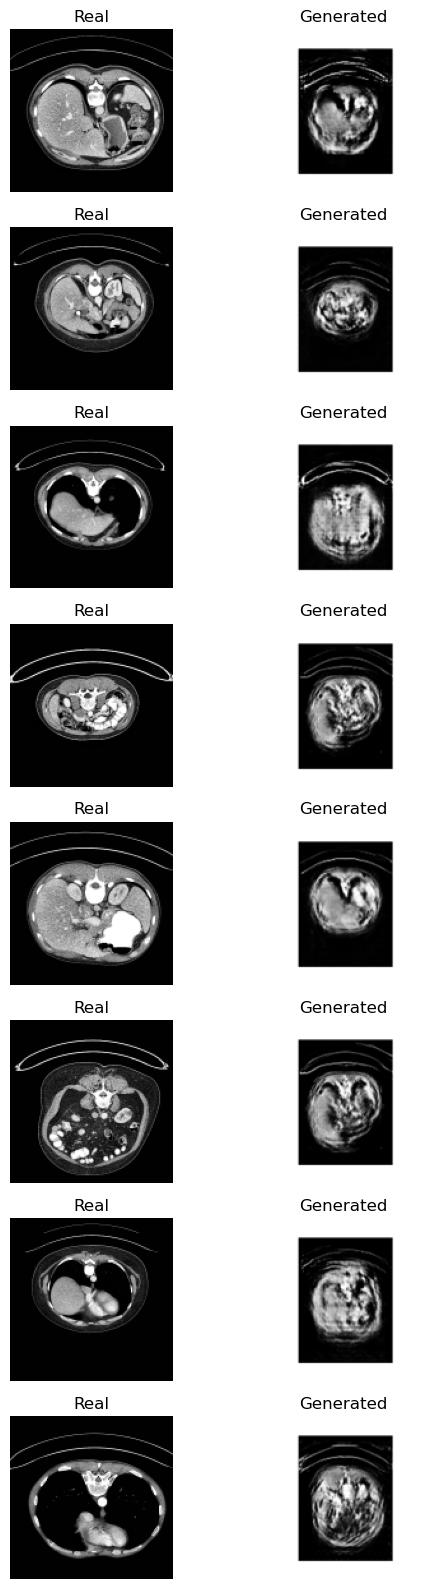

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

def load_real_images(path, max_images=8):
    files = [f for f in os.listdir(path) if f.endswith('.npy')]
    files = random.sample(files, min(max_images, len(files)))  # Random sampling
    images = []
    for f in files:
        img = np.load(os.path.join(path, f))
        img = (img + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
        images.append(img)
    return images

def load_fake_images(path, max_images=8):
    files = [f for f in os.listdir(path) if f.endswith('.png')]
    files = random.sample(files, min(max_images, len(files)))  # Random sampling
    images = []
    for f in files:
        img = Image.open(os.path.join(path, f)).convert('L')
        img = img.resize((128, 128))
        img = np.array(img) / 255.0
        images.append(img)
    return images

def plot_real_vs_generated(real_imgs, fake_imgs):
    num_images = min(len(real_imgs), len(fake_imgs))
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(6, 2 * num_images))

    for i in range(num_images):
        axs[i, 0].imshow(real_imgs[i], cmap='gray')
        axs[i, 0].set_title('Real')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(fake_imgs[i], cmap='gray')
        axs[i, 1].set_title('Generated')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# === Paths ===
real_path = r"C:\ct data set\Pancreas-CT data\Split_Data\train"
fake_path = r"C:\ct data set\Pancreas-CT data\gan_image_individual"

# === Load and Plot ===
real_imgs = load_real_images(real_path, max_images=8)
fake_imgs = load_fake_images(fake_path, max_images=8)
plot_real_vs_generated(real_imgs, fake_imgs)


✅ Generator checkpoint loaded from: C:\ct data set\Pancreas-CT data\nee model\generator\generator_epoch_0200.keras
✅ Discriminator checkpoint loaded from: C:\ct data set\Pancreas-CT data\nee model\discriminator\discriminator_epoch_0200.keras


🧾 Loading real images: 100%|██████████| 16/16 [00:00<00:00, 3198.55it/s]
C:\Users\Abhisek Sahoo\AppData\Local\Temp\ipykernel_22352\12911419.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.85, 1])  # Adjust layout to fit the ROC curve
C:\Users\Abhisek Sahoo\AppData\Local\Temp\ipykernel_22352\12911419.py:112: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 0.85, 1])  # Adjust layout to fit the ROC curve
C:\Users\Abhisek Sahoo\AppData\Local\Temp\ipykernel_22352\12911419.py:113: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig("real_vs_fake_with_roc.png")  # Save to file
C:\Users\Abhisek Sahoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


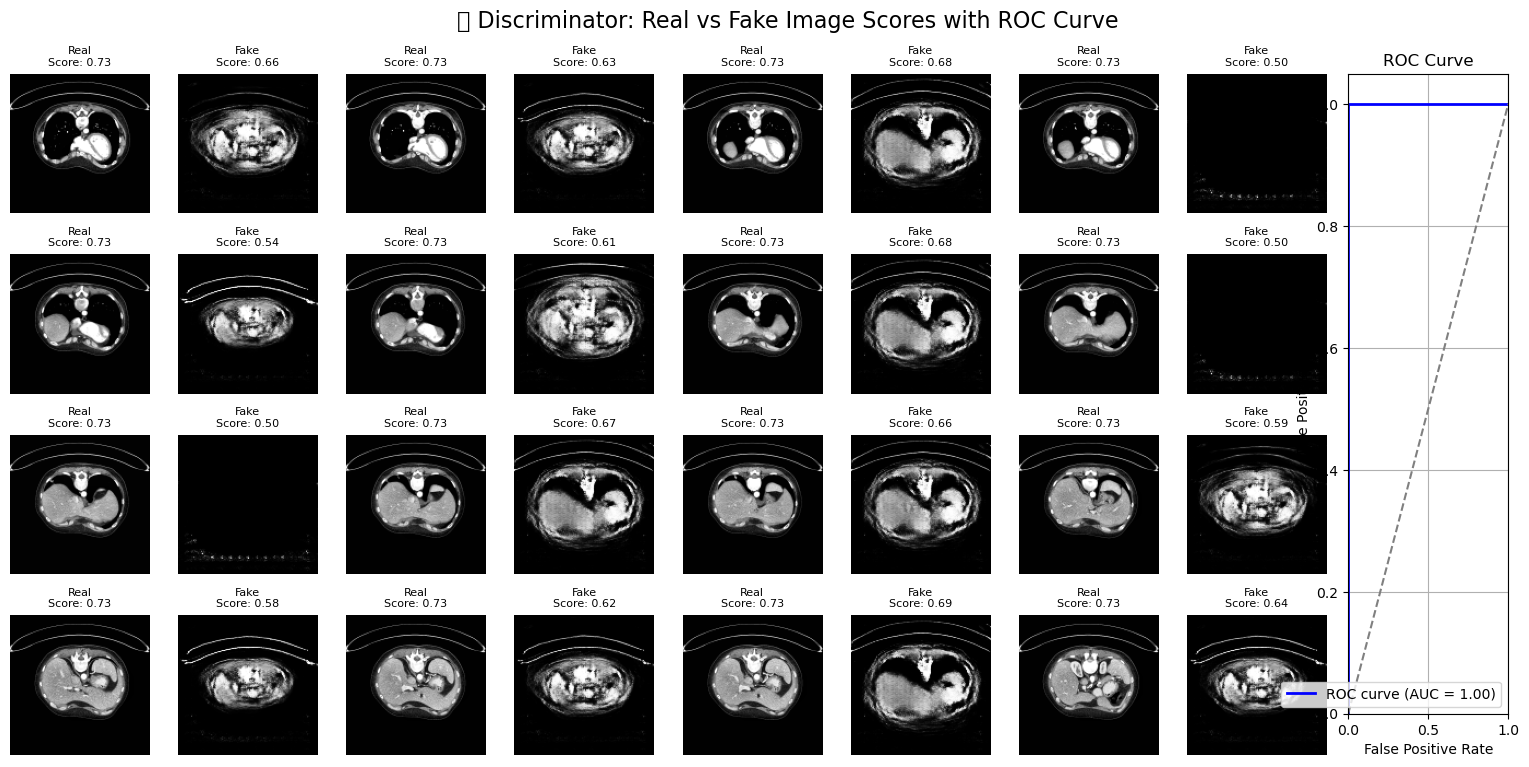


📊 Average Discriminator Score:
   - Real Images: 0.7310
   - Fake Images: 0.6106

📊 AUC: 1.0000


In [84]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

# ===============================
# Config
# ===============================
tf.random.set_seed(42)  # Reproducibility
NOISE_DIM = 100
NUM_IMAGES = 16
MODEL_EPOCH = 200  # Update to the correct epoch
REAL_IMAGES_DIR = r"C:\ct data set\Pancreas-CT data\Split_Data\test"

# Paths
checkpoint_dir = r"C:\ct data set\Pancreas-CT data\nee model"
generator_path = get_latest_model_checkpoint(checkpoint_dir, "generator")
discriminator_path = get_latest_model_checkpoint(checkpoint_dir, "discriminator")

print(f"✅ Generator checkpoint loaded from: {generator_path}")
print(f"✅ Discriminator checkpoint loaded from: {discriminator_path}")

# ===============================
# Load Models
# ===============================
generator = tf.keras.models.load_model(generator_path)
discriminator = tf.keras.models.load_model(discriminator_path)

# ===============================
# Generate Fake Images
# ===============================
noise = tf.random.normal([NUM_IMAGES, NOISE_DIM])
fake_images = generator(noise, training=False)
fake_images_norm = (fake_images + 1.0) / 2.0  # Scale to [0, 1]

# ===============================
# Load Real Images
# ===============================
def load_real_images(folder, num_images):
    images = []
    npy_files = sorted([f for f in os.listdir(folder) if f.endswith('.npy')])[:num_images]
    for file in tqdm(npy_files, desc="🧾 Loading real images"):
        img = np.load(os.path.join(folder, file))
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        images.append(img)
    images = np.array(images, dtype=np.float32)
    return (images - 0.5) * 2.0  # Normalize to [-1, 1]

real_images = load_real_images(REAL_IMAGES_DIR, NUM_IMAGES)
real_images_norm = (real_images + 1.0) / 2.0  # Scale to [0, 1]

# ===============================
# Check Shape Match
# ===============================
if real_images.shape[1:] != fake_images.shape[1:]:
    raise ValueError(f"Shape mismatch: real {real_images.shape[1:]} vs fake {fake_images.shape[1:]}")

# ===============================
# Discriminator Scores
# ===============================
fake_scores = tf.sigmoid(discriminator(fake_images, training=False)).numpy().flatten()
real_scores = tf.sigmoid(discriminator(real_images, training=False)).numpy().flatten()

avg_fake = np.mean(fake_scores)
avg_real = np.mean(real_scores)

# ===============================
# ROC Curve
# ===============================
# True labels: 1 for real, 0 for fake
true_labels = np.concatenate([np.ones_like(real_scores), np.zeros_like(fake_scores)])
scores = np.concatenate([real_scores, fake_scores])

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

# Plot combined image and ROC curve
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

# Display Real and Fake Images
for i in range(NUM_IMAGES):
    ax_real = axes[i // 4, (i % 4) * 2]
    ax_real.imshow(real_images_norm[i, :, :, 0], cmap='gray')
    ax_real.set_title(f"Real\nScore: {real_scores[i]:.2f}", fontsize=8)
    ax_real.axis("off")

    ax_fake = axes[i // 4, (i % 4) * 2 + 1]
    ax_fake.imshow(fake_images_norm[i, :, :, 0], cmap='gray')
    ax_fake.set_title(f"Fake\nScore: {fake_scores[i]:.2f}", fontsize=8)
    ax_fake.axis("off")

# Plot ROC curve on the side of the image grid
roc_ax = fig.add_axes([0.85, 0.1, 0.1, 0.8])
roc_ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
roc_ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random guessing)
roc_ax.set_xlim([0.0, 1.0])
roc_ax.set_ylim([0.0, 1.05])
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title('ROC Curve')
roc_ax.legend(loc="lower right")
roc_ax.grid(True)

# Add the overall title
plt.suptitle("🧠 Discriminator: Real vs Fake Image Scores with ROC Curve", fontsize=16)

# Save and show the combined figure
plt.tight_layout(rect=[0, 0.03, 0.85, 1])  # Adjust layout to fit the ROC curve
plt.savefig("real_vs_fake_with_roc.png")  # Save to file
plt.show()

# ===============================
# Summary
# ===============================
print(f"\n📊 Average Discriminator Score:")
print(f"   - Real Images: {avg_real:.4f}")
print(f"   - Fake Images: {avg_fake:.4f}")
print(f"\n📊 AUC: {roc_auc:.4f}")


In [9]:
import os
import tensorflow as tf

# Define a function to get the latest model checkpoint (updated for .keras files)
def get_latest_model_checkpoint(checkpoint_dir, model_type):
    model_dir = os.path.join(checkpoint_dir, model_type)
    files = [f for f in os.listdir(model_dir) if f.endswith('.keras')]  # Look for .keras files
    
    if not files:
        raise FileNotFoundError(f"No {model_type} checkpoint files found in {model_dir}")
    
    # Sort the files and get the one with the latest epoch number
    latest_file = max(files, key=lambda x: int(x.split('_')[2].split('.')[0]))  # Extract epoch number
    return os.path.join(model_dir, latest_file)

# Paths
checkpoint_dir = r"C:\ct data set\Pancreas-CT data\nee model"
generator_path = get_latest_model_checkpoint(checkpoint_dir, "generator")
discriminator_path = get_latest_model_checkpoint(checkpoint_dir, "discriminator")

print(f"✅ Generator checkpoint loaded from: {generator_path}")
print(f"✅ Discriminator checkpoint loaded from: {discriminator_path}")

# Load models
generator = tf.keras.models.load_model(generator_path)
discriminator = tf.keras.models.load_model(discriminator_path)

print("✅ Generator & Discriminator models successfully loaded!")


✅ Generator checkpoint loaded from: C:\ct data set\Pancreas-CT data\nee model\generator\generator_epoch_0200.keras
✅ Discriminator checkpoint loaded from: C:\ct data set\Pancreas-CT data\nee model\discriminator\discriminator_epoch_0200.keras
✅ Generator & Discriminator models successfully loaded!
